# **Testing Models**

**Author:** Arnav Singh 
**Date:** 2024-11-12

---

## **Abstract**

For this notebook, we will use the OMNI and OCB data from the dayside and Nightside files to explore which edited data works the best with the neural network and random forest. 

In [1]:
### Imports ####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import keras_tuner as kt

In [2]:
nightside_df = pd.read_parquet('data/5minData.parquet')
nightside_df = nightside_df[['b6_date', 'b6_mag_lat', 'b6_mlt' , 'b2i_mag_lat' , 'MAG_AVG_B-VECTOR_nT' , 'BZ__GSM_nT', 'FLOW_PRESSURE_nPa' , 'FLOW_SPEED__GSE_km/s' , '5-M_AE_nT', 'SYM/H_INDEX_nT' , '5-M_PC(N)-INDEX_' , 'PROTON_DENSITY_n/cc', 'dFMP_dt']]
nightside_df.describe()

b6_date     b6_mag_lat         b6_mlt  \
count                         483943  483943.000000  483943.000000   
mean   2002-11-03 23:55:51.074328960     -19.001739      13.762640   
min              1983-12-05 00:36:18     -89.970000       0.000000   
25%       1998-07-13 13:41:58.500000     -75.480000       6.050000   
50%              2003-05-24 10:48:33     -70.870000      17.130000   
75%       2007-08-28 00:15:52.500000      74.060000      20.040000   
max              2012-12-31 22:18:34      90.000000      24.000000   
std                              NaN      73.113363       7.569462   

         b2i_mag_lat  MAG_AVG_B-VECTOR_nT     BZ__GSM_nT  FLOW_PRESSURE_nPa  \
count  483943.000000        483943.000000  483943.000000      483943.000000   
mean      -17.307974             6.248162      -0.207518           2.361047   
min       -89.140000             0.260000     -54.990000           0.020000   
25%       -68.280000             4.180000      -2.140000           1.340000   
50%       -64.790000             5.540000      -0.190000           1.920000   
75%        66.450000             7.420000       1.770000           2.790000   
max        88.880000            56.470000      39.530000          89.510000   
std        65.235929             3.295993       3.645215           1.838813   

       FLOW_SPEED__GSE_km/s      5-M_AE_nT  SYM/H_INDEX_nT  5-M_PC(N)-INDEX_  \
count         483943.000000  483943.000000   483943.000000     483943.000000   
mean             441.493922     215.201666      -13.517668          1.143528   
min              231.800000       2.000000     -475.000000        -16.220000   
25%              360.500000      54.000000      -21.000000          0.200000   
50%              416.800000     129.000000      -10.000000          0.810000   
75%              502.000000     302.000000       -2.000000          1.810000   
max             1130.800000    3274.000000       97.000000         29.080000   
std              107.206271     227.164017       20.911351          1.457352   

       PROTON_DENSITY_n/cc        dFMP_dt  
count        483943.000000  242034.000000  
mean              6.743317    4203.285129  
min               0.090000       0.000000  
25%               3.350000    1002.907335  
50%               5.200000    3017.425966  
75%               8.300000    5934.565018  
max              71.440000  120906.366746  
std               5.383610    4580.793781

In [3]:
dayside_df = pd.read_parquet('data/Dayside.parquet')
dayside_df.describe()

OCB_Date       OCB_mlat        OCB_mlt  \
count                         437644  437644.000000  437644.000000   
mean   2003-06-01 14:36:20.500443008       6.040775      11.697393   
min              1983-12-05 00:47:40     -89.760000       0.110000   
25%       1999-02-11 06:19:51.750000     -77.820000       7.850000   
50%              2004-04-11 13:21:29      72.470000      10.510000   
75%       2008-01-29 00:29:56.500000      78.180000      16.470000   
max              2012-12-31 23:22:24      89.900000      23.970000   
std                              NaN      77.666829       4.706631   

      EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ  TIMESHIFT_seconds  \
count                              437644      437644.000000   
mean           2003-06-01 14:36:19.860800        2362.558701   
min                   1983-12-05 00:50:00      -10189.000000   
25%                   1999-02-11 06:21:15         681.000000   
50%                   2004-04-11 13:20:00        2618.000000   
75%                   2008-01-29 00:30:00        3549.000000   
max                   2012-12-31 23:20:00       10655.000000   
std                                   NaN        1737.990144   

       MAG_AVG_B-VECTOR_nT     BX__GSE_nT     BY__GSM_nT     BZ__GSM_nT  \
count        437644.000000  437644.000000  437644.000000  437644.000000   
mean              5.907477       0.075834      -0.070200      -0.354826   
min               0.260000     -40.990000     -42.590000     -54.400000   
25%               3.920000      -2.600000      -2.710000      -2.150000   
50%               5.250000       0.110000      -0.150000      -0.290000   
75%               7.060000       2.730000       2.560000       1.520000   
max              59.690000      35.230000      47.740000      41.270000   
std               3.111417       3.681877       4.132693       3.377761   

       FLOW_SPEED__GSE_km/s  ...  PROTON_DENSITY_n/cc  FLOW_PRESSURE_nPa  \
count         437644.000000  ...        437644.000000      437644.000000   
mean             436.225657  ...             6.473615           2.223449   
min              234.400000  ...             0.030000           0.010000   
25%              356.100000  ...             3.190000           1.240000   
50%              412.000000  ...             4.970000           1.790000   
75%              496.400000  ...             7.920000           2.650000   
max             1094.500000  ...            70.800000          89.510000   
std              105.762569  ...             5.245134           1.739334   

           5-M_AE_nT  5-M_AL-INDEX_nT  SYM/H_INDEX_nT  5-M_PC(N)-INDEX_  \
count  437644.000000    437644.000000   437644.000000     437644.000000   
mean      212.995867      -137.709360      -13.172677          1.177026   
min         1.000000     -3032.000000     -475.000000        -11.790000   
25%        51.000000      -195.000000      -20.000000          0.240000   
50%       127.000000       -72.000000      -10.000000          0.860000   
75%       303.000000       -24.000000       -2.000000          1.840000   
max      2945.000000        38.000000      109.000000         24.110000   
std       225.276487       166.579801       19.631408          1.417505   

                  BT             qc       sin_term        dFMP_dt  
count  437644.000000  437644.000000  213160.000000  213160.000000  
mean        4.429847      -0.058896       0.461304    4097.295290  
min         0.010000      -3.141593       0.000000       0.000000  
25%         2.455952      -1.720544       0.147689    1002.849111  
50%         3.813325      -0.146484       0.437412    2980.533893  
75%         5.611355       1.615992       0.763063    5848.386906  
max        57.881329       3.141593       1.000000  111132.480707  
std         2.999276       1.830629       0.331910    4317.031442  

[8 rows x 23 columns]

In [4]:
nightsideN_df = nightside_df[(nightside_df['b6_mag_lat'] > 50) & (nightside_df['b6_mag_lat'] < 85)]
nightsideN_df.describe()

b6_date     b6_mag_lat         b6_mlt  \
count                         168720  168720.000000  168720.000000   
mean   2001-10-14 10:03:36.336119040      76.142683      15.233504   
min              1983-12-05 00:36:18      50.220000       0.000000   
25%       1997-07-10 01:07:48.250000      72.950000       9.630000   
50%       2002-09-10 01:38:53.500000      76.050000      17.350000   
75%    2006-12-20 19:52:23.249999872      79.420000      19.220000   
max              2012-12-31 16:30:13      84.990000      24.000000   
std                              NaN       4.218707       5.744538   

         b2i_mag_lat  MAG_AVG_B-VECTOR_nT     BZ__GSM_nT  FLOW_PRESSURE_nPa  \
count  168720.000000        168720.000000  168720.000000      168720.000000   
mean       68.006480             6.388529      -0.399888           2.454799   
min        22.420000             0.300000     -54.990000           0.050000   
25%        65.720000             4.310000      -2.330000           1.410000   
50%        68.000000             5.680000      -0.350000           2.000000   
75%        70.350000             7.570000       1.650000           2.900000   
max        88.880000            56.060000      37.630000          89.510000   
std         3.499748             3.316845       3.683287           1.918962   

       FLOW_SPEED__GSE_km/s      5-M_AE_nT  SYM/H_INDEX_nT  5-M_PC(N)-INDEX_  \
count         168720.000000  168720.000000   168720.000000     168720.000000   
mean             447.279442     237.781911      -14.620887          1.285841   
min              246.600000       2.000000     -470.000000        -16.220000   
25%              364.500000      61.000000      -22.000000          0.290000   
50%              422.100000     151.000000      -11.000000          0.960000   
75%              510.300000     339.000000       -2.000000          2.000000   
max             1091.300000    3011.000000       97.000000         21.640000   
std              109.069541     239.954850       21.642193          1.509627   

       PROTON_DENSITY_n/cc        dFMP_dt  
count        168720.000000   83216.000000  
mean              6.847319    4457.822506  
min               0.100000       0.000000  
25%               3.410000    1127.186106  
50%               5.270000    3246.689337  
75%               8.440000    6292.942584  
max              71.440000  109286.901308  
std               5.417004    4744.192839

In [5]:
nightsideS_df = nightside_df[(nightside_df['b6_mag_lat'] < -50) & (nightside_df['b6_mag_lat'] > -85)]
nightsideS_df.describe()

b6_date     b6_mag_lat         b6_mlt  \
count                         299357  299357.000000  299357.000000   
mean   2003-05-03 14:41:06.741632768     -74.519601      13.036397   
min              1983-12-05 00:48:09     -84.990000       0.000000   
25%              1998-12-29 14:41:39     -77.640000       4.090000   
50%              2003-08-14 11:53:06     -73.980000      17.110000   
75%              2007-11-02 02:09:54     -71.290000      20.630000   
max              2012-12-31 22:18:34     -50.160000      24.000000   
std                              NaN       4.314957       8.394499   

         b2i_mag_lat  MAG_AVG_B-VECTOR_nT     BZ__GSM_nT  FLOW_PRESSURE_nPa  \
count  299357.000000        299357.000000  299357.000000      299357.000000   
mean      -67.034516             6.158361      -0.202702           2.295949   
min       -89.140000             0.260000     -54.400000           0.020000   
25%       -69.550000             4.130000      -2.100000           1.310000   
50%       -67.440000             5.460000      -0.170000           1.860000   
75%       -65.320000             7.320000       1.750000           2.720000   
max       -20.020000            56.470000      36.560000          73.140000   
std         5.242411             3.236922       3.562904           1.763516   

       FLOW_SPEED__GSE_km/s      5-M_AE_nT  SYM/H_INDEX_nT  5-M_PC(N)-INDEX_  \
count          299357.00000  299357.000000   299357.000000     299357.000000   
mean              438.71811     208.220967      -13.299913          1.096792   
min               231.80000       2.000000     -475.000000        -13.410000   
25%               358.80000      53.000000      -21.000000          0.170000   
50%               414.50000     124.000000      -10.000000          0.760000   
75%               497.70000     291.000000       -2.000000          1.730000   
max              1130.80000    3059.000000       95.000000         21.900000   
std               106.00662     220.774769       20.562989          1.420975   

       PROTON_DENSITY_n/cc        dFMP_dt  
count        299357.000000  150716.000000  
mean              6.635695    4144.253038  
min               0.090000       0.000000  
25%               3.310000    1005.700199  
50%               5.120000    2992.683487  
75%               8.150000    5849.907941  
max              70.800000   95465.606665  
std               5.299043    4499.875385

In [6]:
daysideN_df = dayside_df[(dayside_df['OCB_mlat'] > 50) & (dayside_df['OCB_mlat'] < 85)]
daysideN_df.describe()

OCB_Date       OCB_mlat        OCB_mlt  \
count                         229180  229180.000000  229180.000000   
mean   2003-08-10 20:59:24.197739776      77.508448      12.315415   
min              1983-12-05 01:36:04      50.990000       0.610000   
25%              1999-04-30 08:02:18      75.290000       8.930000   
50%              2004-06-09 09:20:05      77.710000      11.610000   
75%    2008-02-10 16:37:53.750000128      79.860000      16.350000   
max              2012-12-31 23:22:24      84.990000      22.780000   
std                              NaN       3.355374       4.127090   

      EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ  TIMESHIFT_seconds  \
count                              229180      229180.000000   
mean        2003-08-10 20:59:23.538703104        2376.751881   
min                   1983-12-05 01:35:00      -10189.000000   
25%                   1999-04-30 08:03:45         770.000000   
50%                   2004-06-09 09:20:00        2624.000000   
75%                   2008-02-10 16:36:15        3542.000000   
max                   2012-12-31 23:20:00       10640.000000   
std                                   NaN        1720.941323   

       MAG_AVG_B-VECTOR_nT     BX__GSE_nT     BY__GSM_nT     BZ__GSM_nT  \
count        229180.000000  229180.000000  229180.000000  229180.000000   
mean              5.960242       0.202947      -0.289296      -0.570114   
min               0.270000     -40.510000     -42.590000     -54.400000   
25%               3.960000      -2.490000      -2.910000      -2.370000   
50%               5.290000       0.290000      -0.410000      -0.490000   
75%               7.110000       2.850000       2.350000       1.340000   
max              59.690000      30.940000      47.740000      38.870000   
std               3.139569       3.692592       4.152250       3.405304   

       FLOW_SPEED__GSE_km/s  ...  PROTON_DENSITY_n/cc  FLOW_PRESSURE_nPa  \
count         229180.000000  ...        229180.000000      229180.000000   
mean             437.956018  ...             6.501547           2.250126   
min              234.400000  ...             0.090000           0.030000   
25%              357.000000  ...             3.200000           1.250000   
50%              413.600000  ...             4.990000           1.810000   
75%              499.600000  ...             7.960000           2.690000   
max             1068.000000  ...            69.690000          89.510000   
std              106.384178  ...             5.287554           1.775059   

           5-M_AE_nT  5-M_AL-INDEX_nT  SYM/H_INDEX_nT  5-M_PC(N)-INDEX_  \
count  229180.000000    229180.000000   229180.000000     229180.000000   
mean      226.418217      -146.001030      -14.281351          1.306133   
min         2.000000     -2420.000000     -462.000000         -8.490000   
25%        54.000000      -212.000000      -22.000000          0.310000   
50%       144.000000       -82.000000      -11.000000          0.970000   
75%       330.000000       -25.000000       -2.000000          1.990000   
max      2945.000000        38.000000      109.000000         24.110000   
std       229.726672       170.043717       20.237084          1.434884   

                  BT             qc       sin_term        dFMP_dt  
count  229180.000000  229180.000000  105969.000000  105969.000000  
mean        4.478826      -0.137941       0.485856    4339.118939  
min         0.010000      -3.141593       0.000000       0.000000  
25%         2.485141      -1.822249       0.168602    1121.918793  
50%         3.854458      -0.428466       0.478764    3253.975000  
75%         5.665803       1.629181       0.797081    6218.852059  
max        57.881329       3.141593       1.000000  111132.480707  
std         3.030847       1.871436       0.334840    4441.548693  

[8 rows x 23 columns]

In [7]:
daysideS_df = dayside_df[(dayside_df['OCB_mlat'] < -50) & (dayside_df['OCB_mlat'] > -85)]
daysideS_df.describe()

OCB_Date       OCB_mlat        OCB_mlt  \
count                         197206  197206.000000  197206.000000   
mean   2003-02-09 14:53:51.176308096     -77.748569      11.000908   
min              1983-12-05 00:47:40     -84.990000       0.110000   
25%              1998-10-29 19:22:28     -80.100000       6.800000   
50%              2003-12-29 10:54:20     -78.100000       9.250000   
75%              2007-12-05 18:19:49     -75.590000      16.720000   
max              2012-12-31 23:15:22     -50.070000      23.790000   
std                              NaN       3.447356       5.215059   

      EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ  TIMESHIFT_seconds  \
count                              197206      197206.000000   
mean        2003-02-09 14:53:50.577670144        2333.205937   
min                   1983-12-05 00:50:00      -10076.000000   
25%                   1998-10-29 19:21:15         566.000000   
50%                   2003-12-29 10:55:00        2595.000000   
75%                   2007-12-05 18:18:45        3548.000000   
max                   2012-12-31 23:15:00       10655.000000   
std                                   NaN        1759.504472   

       MAG_AVG_B-VECTOR_nT     BX__GSE_nT     BY__GSM_nT     BZ__GSM_nT  \
count        197206.000000  197206.000000  197206.000000  197206.000000   
mean              5.831087      -0.068984       0.167522      -0.234591   
min               0.260000     -40.990000     -34.050000     -52.160000   
25%               3.880000      -2.710000      -2.490000      -1.980000   
50%               5.190000      -0.080000       0.140000      -0.160000   
75%               6.980000       2.590000       2.770000       1.600000   
max              55.460000      35.230000      41.360000      31.630000   
std               3.061440       3.655076       4.096544       3.288972   

       FLOW_SPEED__GSE_km/s  ...  PROTON_DENSITY_n/cc  FLOW_PRESSURE_nPa  \
count         197206.000000  ...        197206.000000      197206.000000   
mean             434.108198  ...             6.450969           2.194687   
min              236.400000  ...             0.030000           0.010000   
25%              354.800000  ...             3.190000           1.230000   
50%              410.300000  ...             4.970000           1.770000   
75%              492.700000  ...             7.900000           2.620000   
max             1094.500000  ...            70.800000          59.800000   
std              105.160329  ...             5.177858           1.684780   

           5-M_AE_nT  5-M_AL-INDEX_nT  SYM/H_INDEX_nT  5-M_PC(N)-INDEX_  \
count  197206.000000    197206.000000   197206.000000     197206.000000   
mean      204.908725      -133.294641      -12.243948          1.078908   
min         1.000000     -3032.000000     -475.000000        -11.790000   
25%        51.000000      -184.000000      -19.000000          0.210000   
50%       119.000000       -68.000000       -9.000000          0.790000   
75%       284.000000       -24.000000       -1.000000          1.720000   
max      2892.000000        31.000000       93.000000         20.610000   
std       222.199205       164.430474       18.976535          1.385477   

                  BT             qc       sin_term        dFMP_dt  
count  197206.000000  197206.000000  101253.000000  101253.000000  
mean        4.358688       0.026313       0.447528    3952.242345  
min         0.014142      -3.141593       0.000000       0.000000  
25%         2.418140      -1.622386       0.143708     976.384286  
50%         3.758324       0.139160       0.414833    2849.333986  
75%         5.533263       1.635300       0.736453    5602.255374  
max        55.393936       3.141593       1.000000   88115.279703  
std         2.946837       1.802158       0.326598    4211.463890  

[8 rows x 23 columns]

In [13]:
### ML MODELS ###
def create_latitude_bins(y, n_bins=10):
    """
    Create latitude bins with approximately equal number of samples in each bin
    """
    # Get bin edges using quantiles
    _, bin_edges = pd.qcut(y, q=n_bins, retbins=True, duplicates='drop')
    
    # Create bin labels
    bin_labels = [f"{bin_edges[i]:.1f} to {bin_edges[i+1]:.1f}" 
                 for i in range(len(bin_edges)-1)]
    
    # Assign data points to bins
    bins = pd.cut(y, bins=bin_edges, labels=False, include_lowest=True)
    
    return bins, bin_labels, bin_edges

def evaluate_classifier(y_true, y_pred, model_name):
    """Calculate and return evaluation metrics for a classification model"""
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Macro Avg F1': report['macro avg']['f1-score'],
        'Weighted Avg F1': report['weighted avg']['f1-score']
    }

def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    """Plot confusion matrix for the classifier"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


def predict_class_with_all_models(input_data, models, scaler, bin_edges, bin_labels):
    """Make classification predictions using all trained models"""
    scaled_input = scaler.transform(input_data)
    predictions = {}
    
    for name, model in models.items():
        pred_bin = model.predict(scaled_input)[0]
        predictions[name] = bin_labels[pred_bin]
        
    return predictions


def create_nn_classifier(input_shape, n_classes):
    """Create a robust neural network classifier
    
    Args:
        input_shape (tuple): Shape of input features (n_features,)
        n_classes (int): Number of output classes
    """
    # Ensure input_shape is a tuple
    if isinstance(input_shape, int):
        input_shape = (input_shape,)
        
    model = tf.keras.Sequential([
        # Input layer with explicit shape specification
        layers.Input(shape=input_shape),
        
        # First dense layer with batch normalization and dropout
        layers.Dense(512, kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        
        # Second dense layer
        layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        
        # Third dense layer
        layers.Dense(128, kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(n_classes, activation='softmax')
    ])
    
    # Use a fixed learning rate instead of a scheduler
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_classification_models(df, features, target, hemisphere='north', n_bins=10):
    """
    Train and evaluate multiple classification models including neural network
    
    Args:
        df (pd.DataFrame): Input dataframe containing features and target
        features (list): List of feature column names
        target (str): Name of the target column
        hemisphere (str): 'north' or 'south', used for plot titles
        n_bins (int): Number of bins for latitude classification
        
    Returns:
        tuple: (results_df, trained_models, scaler, bin_edges, bin_labels, history)
    """
    # Prepare data
    df = df.dropna(subset=features + [target])
    X = df[features]
    y = df[target]
    
    # Create bins for latitude values
    y_binned, bin_labels, bin_edges = create_latitude_bins(y, n_bins)
    
    # Add pairwise relationships plot at the start of the analysis
    plot_pairwise_relationships(df, features, target)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y_binned, test_size=0.2, random_state=42, stratify=y_binned)
    
    # Scale features before training
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize models dictionary
    models = {
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [200],
                'max_depth': [20],
                'min_samples_split': [2]
            }
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5]
            }
        }
    }
    
    # Train and evaluate traditional models
    results = []
    trained_models = {}
    
    for name, config in models.items():
        print(f"\nTraining {name}...")
        
        grid_search = GridSearchCV(
            config['model'],
            config['params'],
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )
        
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        trained_models[name] = best_model
        
        # Add learning curves plot for each model
        plot_learning_curves(X_train_scaled, y_train, best_model)
        
        y_pred = best_model.predict(X_test_scaled)
        metrics = evaluate_classifier(y_test, y_pred, name)
        results.append(metrics)
        
        plot_confusion_matrix(y_test, y_pred, bin_labels, name)
        
        # Add new visualizations for each traditional model
        if hasattr(best_model, 'predict_proba'):
            y_pred_proba = best_model.predict_proba(X_test_scaled)
            plot_multiclass_roc_curves(y_test, y_pred_proba, bin_labels, name)
        
        plot_prediction_distribution(y_pred, bin_labels, name)
        
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=bin_labels))
    
    # Add feature importance plot after training traditional models
    plot_feature_importance(trained_models, features, bin_labels)
    
    # Train Neural Network
    print("\nTraining Neural Network...")
    
    # Create and train neural network
    nn_model = create_nn_classifier((X_train_scaled.shape[1],), n_bins)
    
    # Modified callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )
    
    history = nn_model.fit(
        X_train_scaled,
        y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Evaluate neural network
    y_pred_nn = np.argmax(nn_model.predict(X_test_scaled), axis=1)
    nn_metrics = evaluate_classifier(y_test, y_pred_nn, "Neural Network")
    results.append(nn_metrics)
    trained_models["Neural Network"] = nn_model
    
    # Add prediction distribution plot for neural network
    plot_prediction_distribution(y_pred_nn, bin_labels, "Neural Network")
    
    # Plot confusion matrix for neural network
    plot_confusion_matrix(y_test, y_pred_nn, bin_labels, "Neural Network")
    
    # Get probability predictions for neural network and plot ROC curves
    y_pred_proba_nn = nn_model.predict(X_test_scaled)
    plot_multiclass_roc_curves(y_test, y_pred_proba_nn, bin_labels, "Neural Network")
    
    print("\nNeural Network Classification Report:")
    print(classification_report(y_test, y_pred_nn, target_names=bin_labels))
    
    # Plot neural network training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Plot model comparisons including neural network
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.barplot(x='Model', y='Accuracy', data=results_df)
    plt.xticks(rotation=45)
    plt.title(f'Accuracy Comparison ({hemisphere} hemisphere)')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='Model', y='Weighted Avg F1', data=results_df)
    plt.xticks(rotation=45)
    plt.title(f'Weighted F1 Score Comparison ({hemisphere} hemisphere)')
    
    plt.tight_layout()
    plt.show()
    
    return results_df, trained_models, scaler, bin_edges, bin_labels, history

from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

def plot_feature_importance(models, feature_names, bin_labels):
    """Plot feature importance for tree-based models"""
    plt.figure(figsize=(12, 6))
    
    # Only plot for models that have feature_importances_ attribute
    for name, model in models.items():
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            
            plt.subplot(1, 2, 1 if name == 'Random Forest' else 2)
            sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices])
            plt.title(f'{name} Feature Importance')
            plt.xlabel('Importance Score')
    
    plt.tight_layout()
    plt.show()

def plot_multiclass_roc_curves(y_test, y_pred_proba, bin_labels, model_name):
    """
    Plot ROC curves for both binary and multiclass classification
    
    Args:
        y_test: True labels
        y_pred_proba: Predicted probabilities
        bin_labels: Labels for the bins
        model_name: Name of the model for the plot title
    """
    plt.figure(figsize=(10, 8))
    
    # Handle binary classification differently from multiclass
    if len(bin_labels) == 2:
        # For binary classification, we only need the probability of class 1
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        
    else:
        # For multiclass, binarize the labels and plot curve for each class
        y_test_bin = label_binarize(y_test, classes=np.arange(len(bin_labels)))
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(len(bin_labels)):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f'Class {bin_labels[i]} (AUC = {roc_auc[i]:.2f})')
    
    # Add the diagonal line for reference
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_prediction_distribution(y_pred, bin_labels, model_name):
    """Plot distribution of predictions across latitude bins"""
    plt.figure(figsize=(12, 6))
    
    pred_counts = pd.Series(y_pred).value_counts().sort_index()
    sns.barplot(x=bin_labels, y=pred_counts.values)
    
    plt.title(f'Distribution of Predictions - {model_name}')
    plt.xlabel('Latitude Bins')
    plt.ylabel('Number of Predictions')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_learning_curves(X_train, y_train, model, cv=5):
    """Plot learning curves to diagnose bias-variance tradeoff"""
    from sklearn.model_selection import learning_curve
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10))
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation Score')
    
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title(f'Learning Curves - {type(model).__name__}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_pairwise_relationships(df, features, target, sample_size=1000):
    """Plot pairwise relationships between features and target"""
    # Sample data if too large
    if len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=42)
    else:
        df_sample = df.copy()
    
    # Create pair plot
    plt.figure(figsize=(15, 15))
    sns.pairplot(df_sample[features + [target]], 
                hue=target,
                diag_kind='kde',
                plot_kws={'alpha': 0.6})
    plt.suptitle('Pairwise Relationships between Features', y=1.02)
    plt.show()

Training North Hemisphere Models...


/Users/beastxgamer/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1500 with 0 Axes>

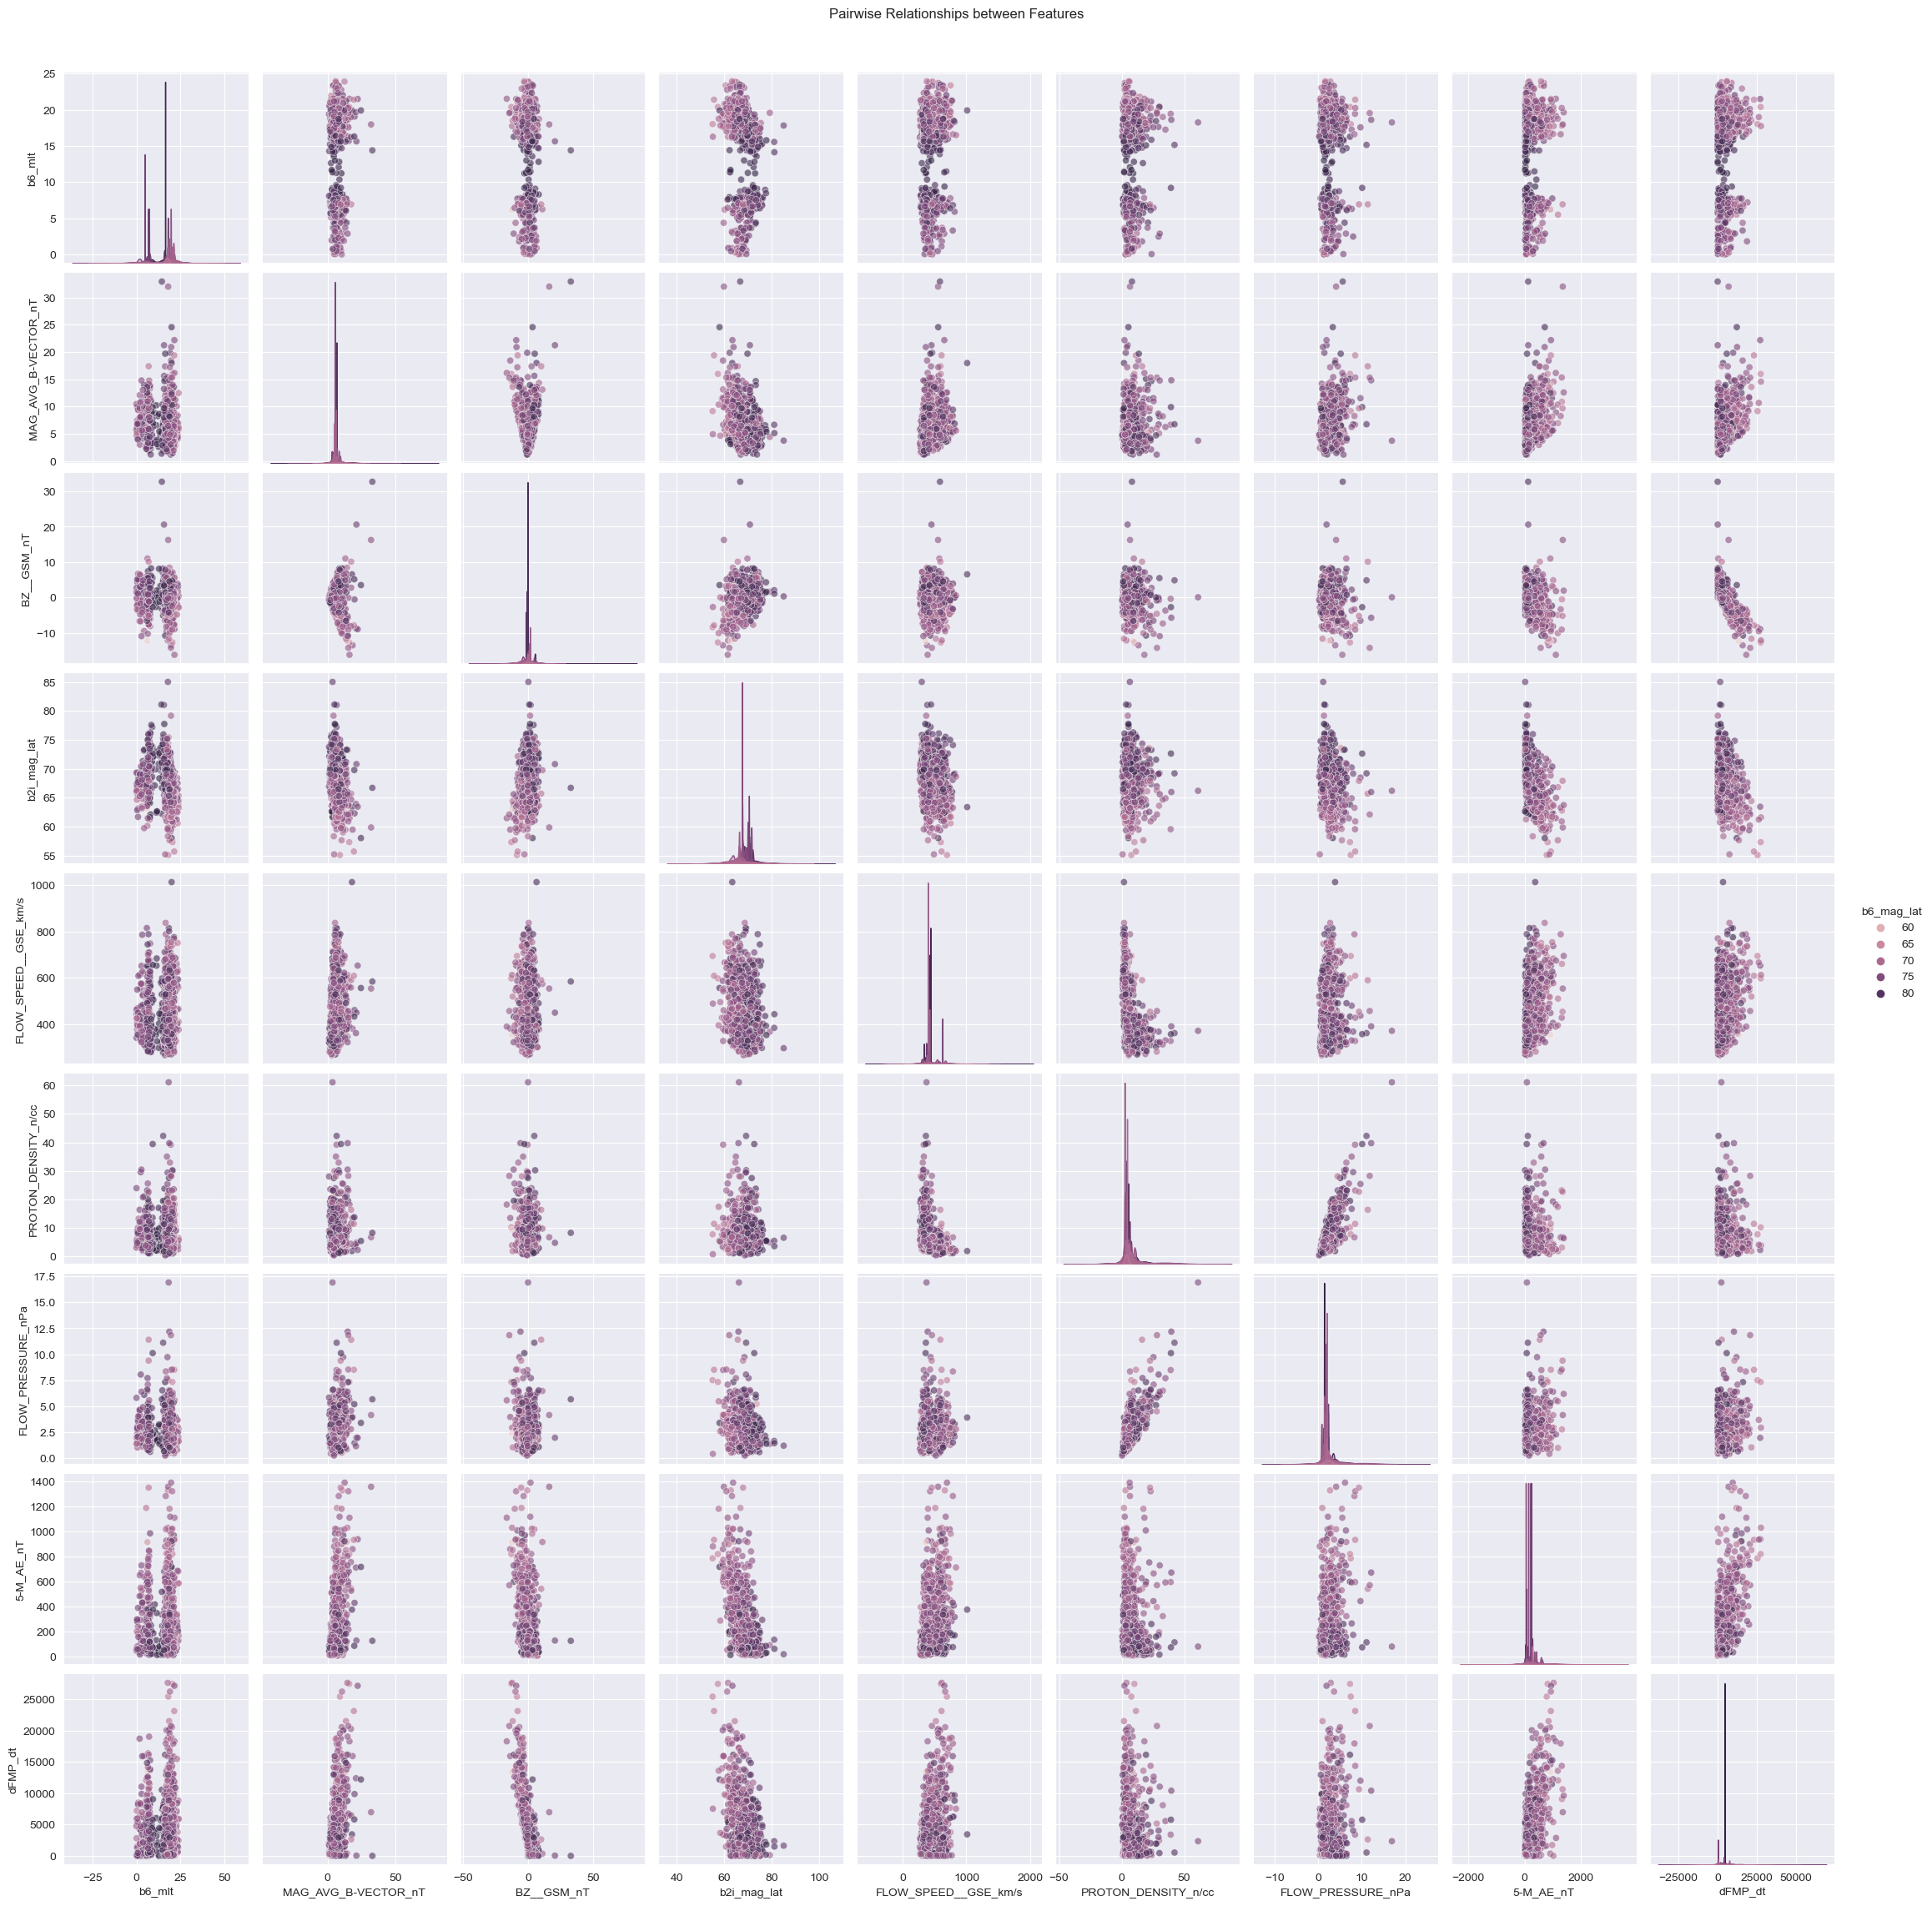


Training Random Forest...


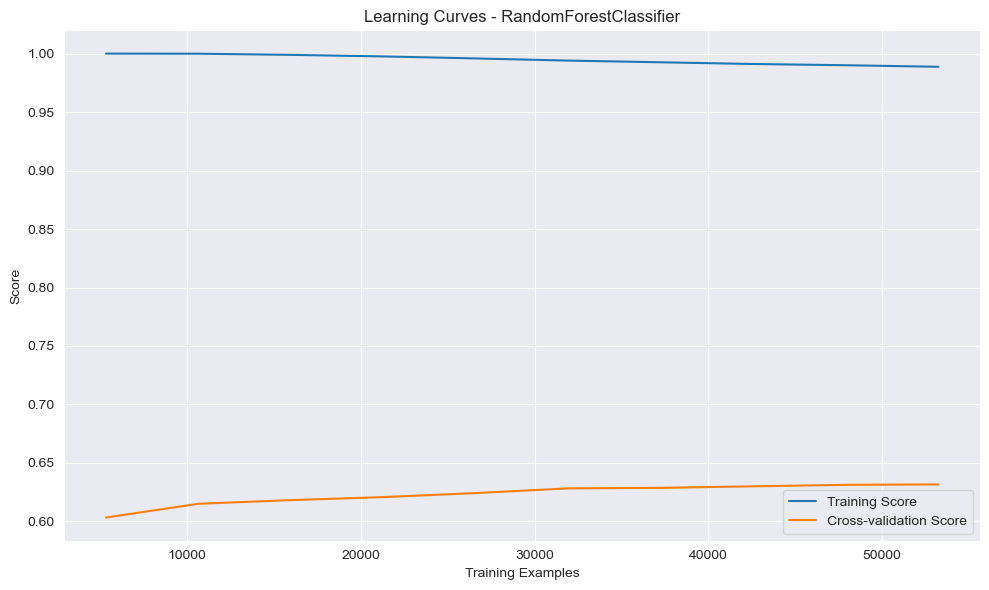

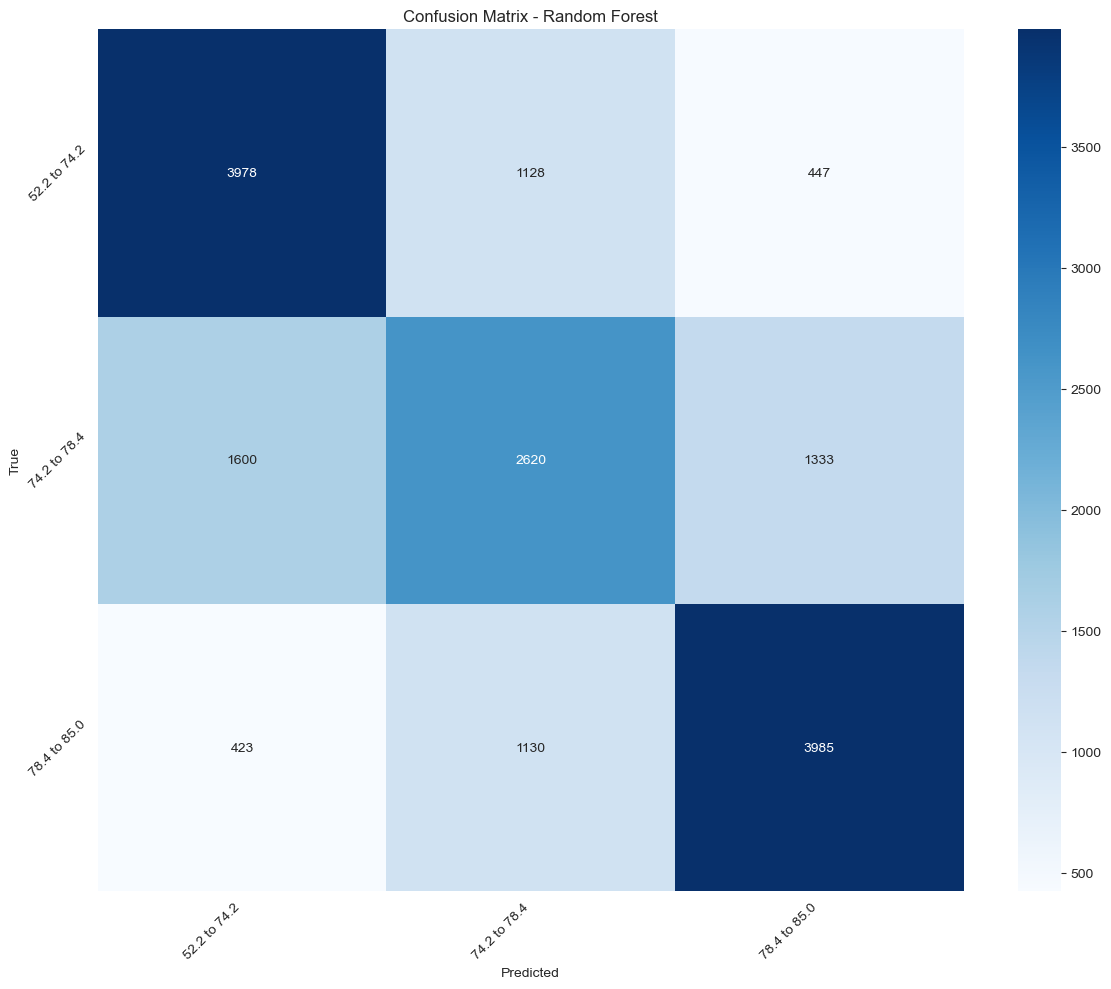

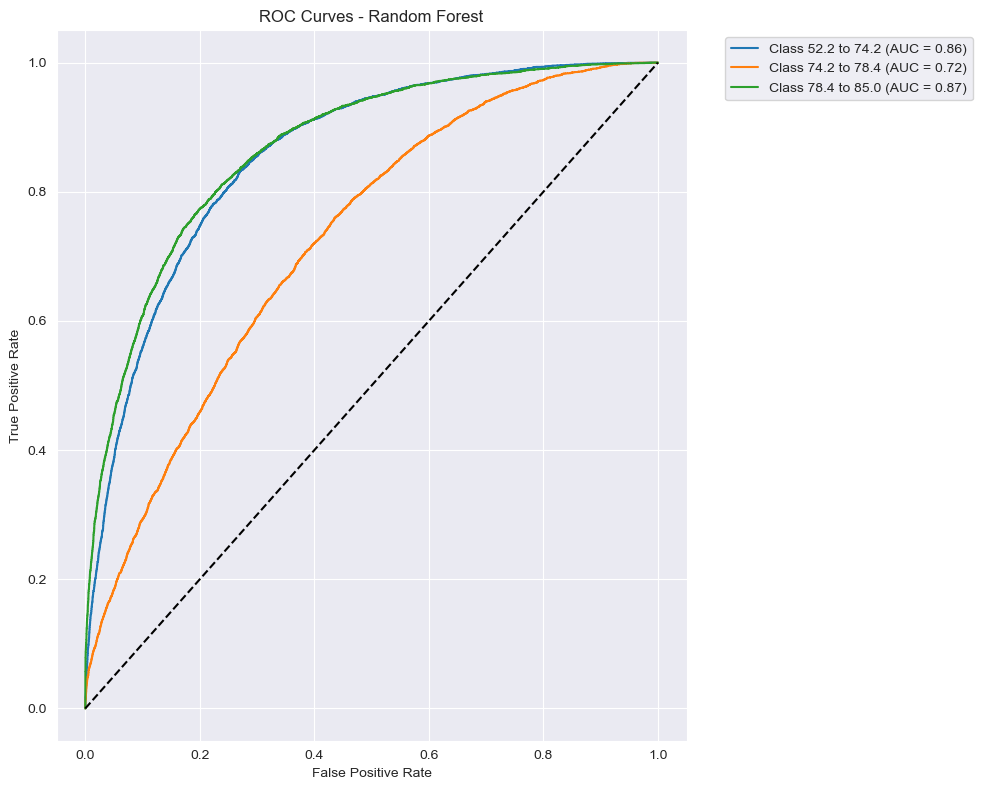

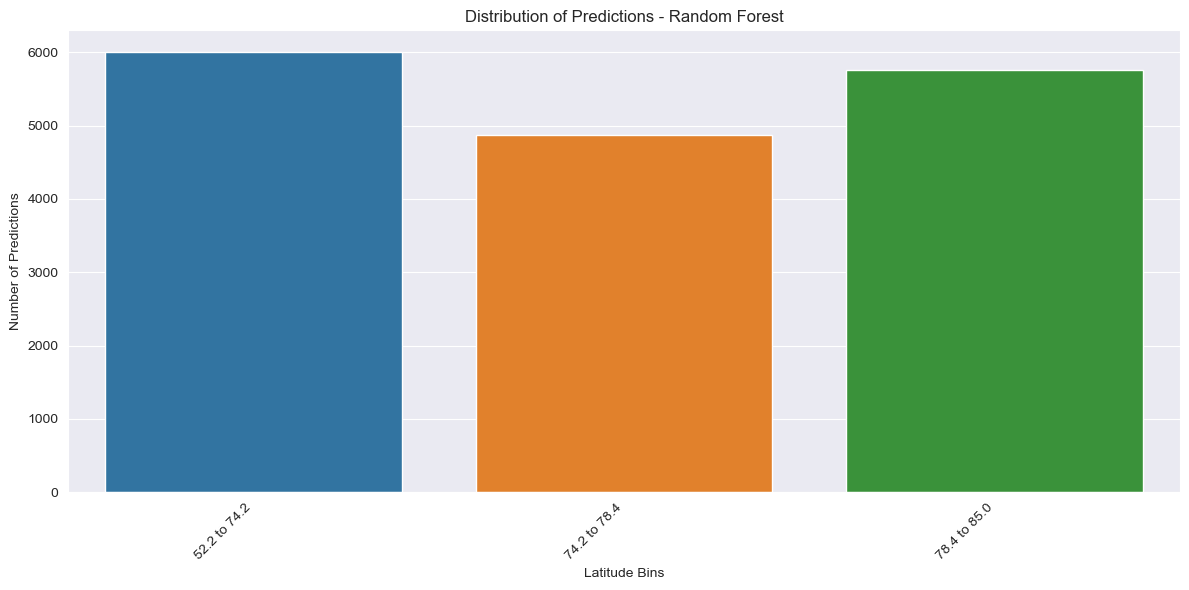

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

52.2 to 74.2       0.66      0.72      0.69      5553
74.2 to 78.4       0.54      0.47      0.50      5553
78.4 to 85.0       0.69      0.72      0.71      5538

    accuracy                           0.64     16644
   macro avg       0.63      0.64      0.63     16644
weighted avg       0.63      0.64      0.63     16644


Training Decision Tree...


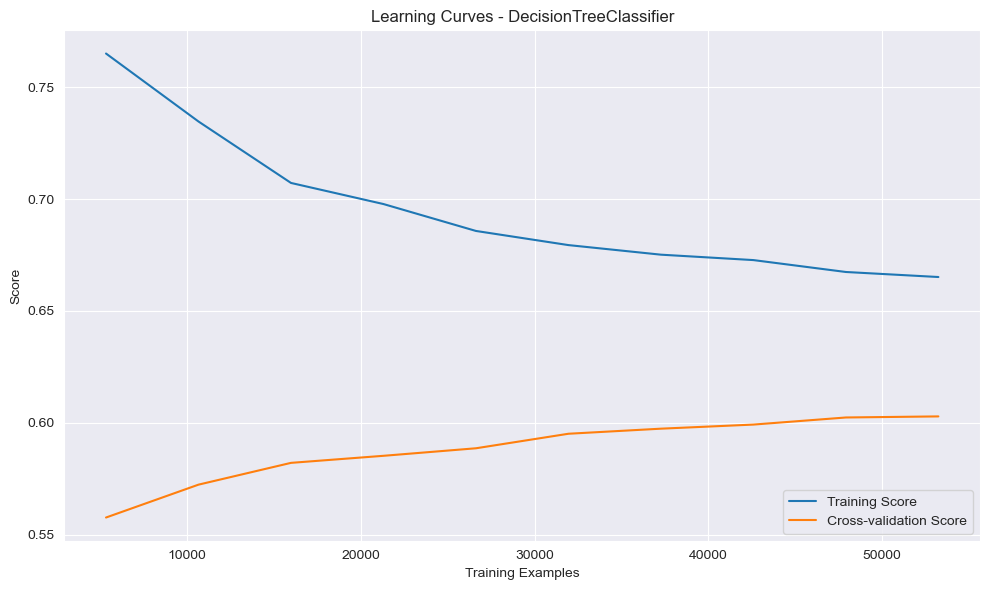

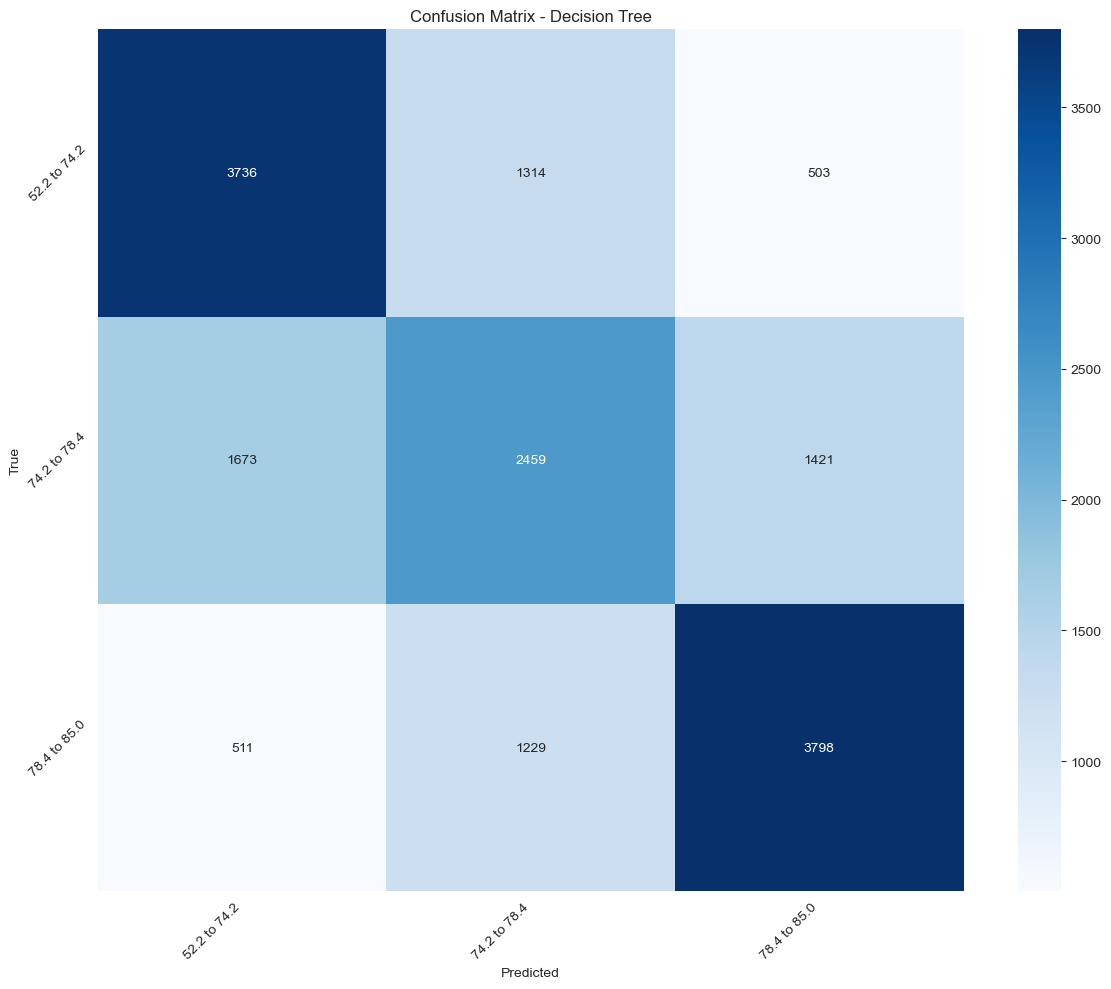

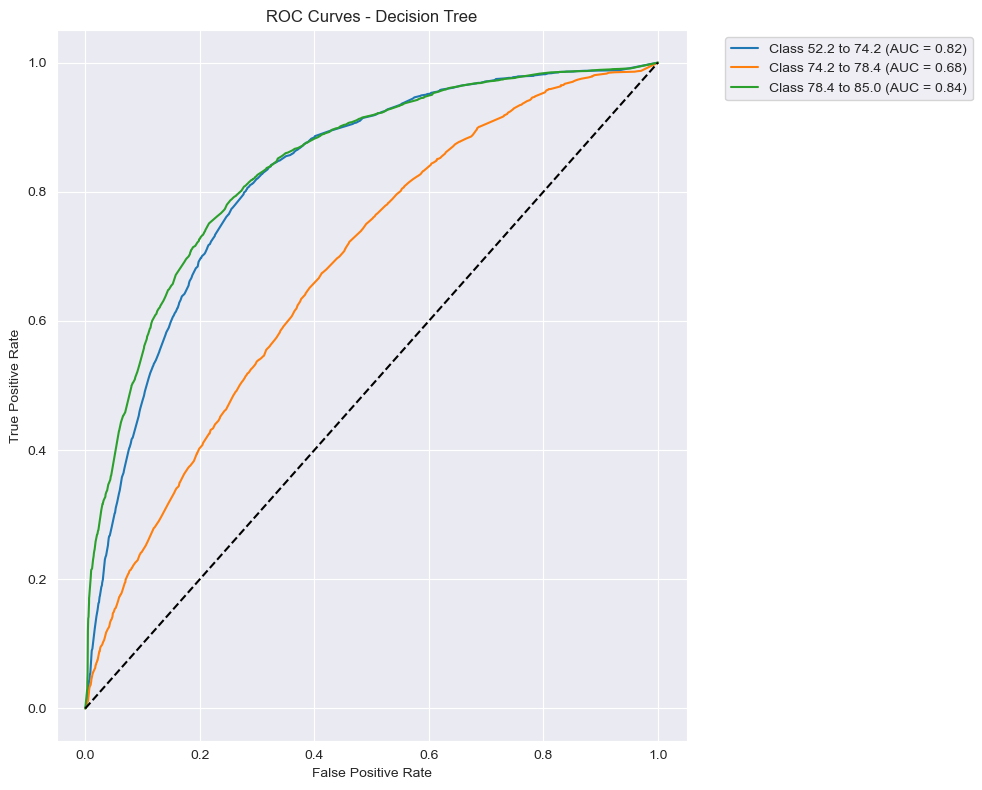

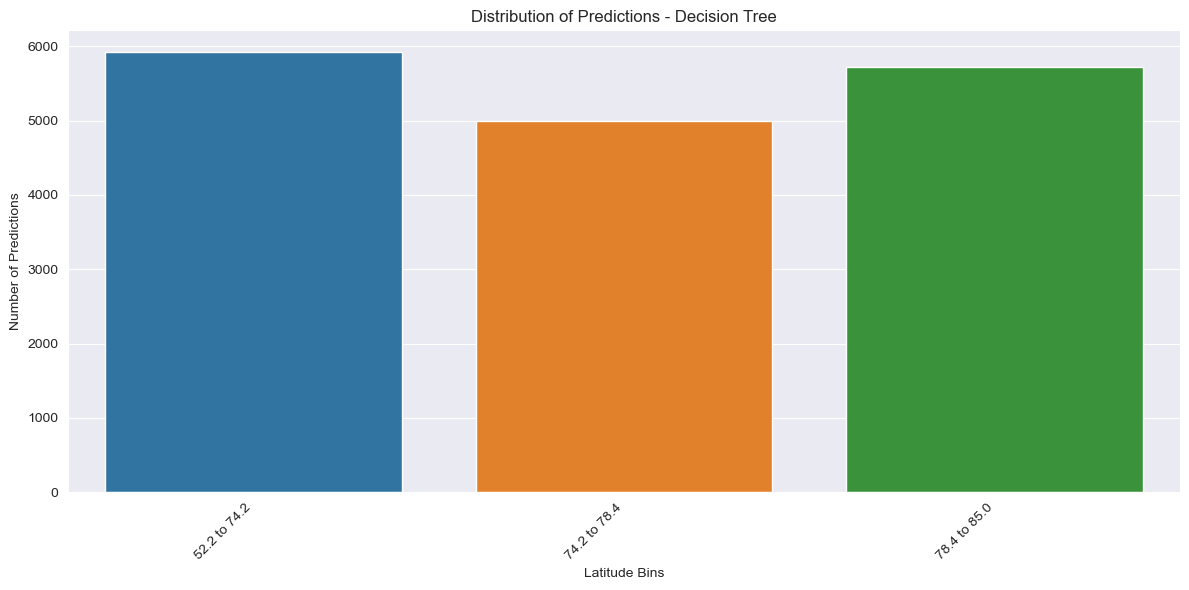

Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 5}

Classification Report:
              precision    recall  f1-score   support

52.2 to 74.2       0.63      0.67      0.65      5553
74.2 to 78.4       0.49      0.44      0.47      5553
78.4 to 85.0       0.66      0.69      0.67      5538

    accuracy                           0.60     16644
   macro avg       0.60      0.60      0.60     16644
weighted avg       0.60      0.60      0.60     16644



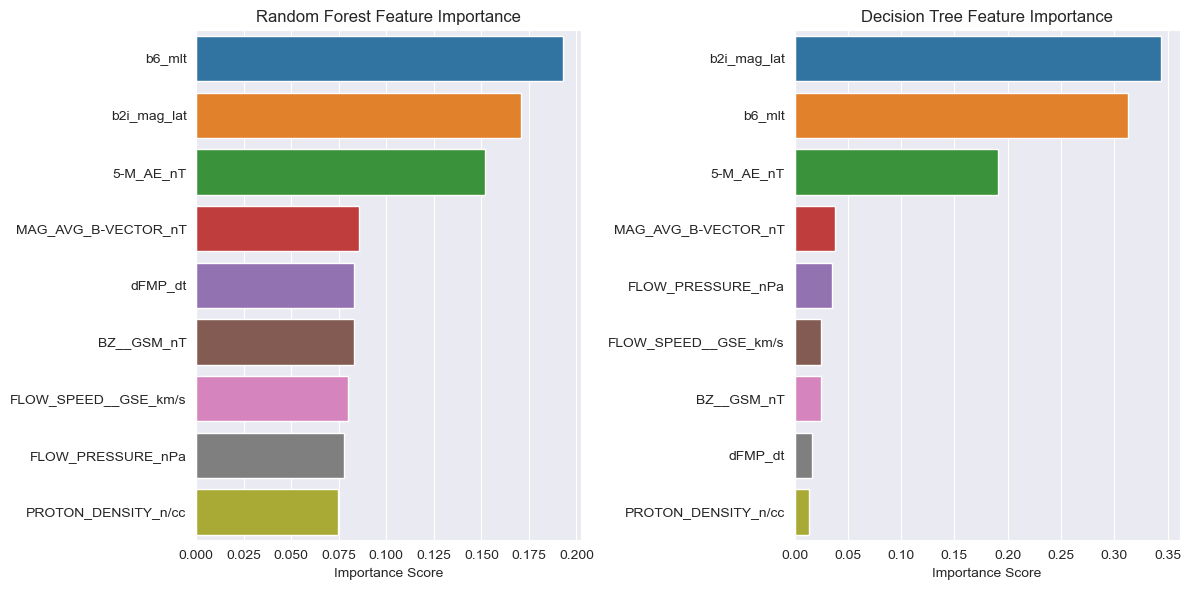


Training Neural Network...
Epoch 1/50
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5268 - loss: 1.0377 - val_accuracy: 0.5902 - val_loss: 0.9167 - learning_rate: 0.0010
Epoch 2/50
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5775 - loss: 0.9409 - val_accuracy: 0.5983 - val_loss: 0.8993 - learning_rate: 0.0010
Epoch 3/50
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5746 - loss: 0.9239 - val_accuracy: 0.6000 - val_loss: 0.8900 - learning_rate: 0.0010
Epoch 4/50
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5815 - loss: 0.9132 - val_accuracy: 0.5973 - val_loss: 0.8845 - learning_rate: 0.0010
Epoch 5/50
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5831 - loss: 0.9058 - val_accuracy: 0.6032 - val_loss: 0.8849 - learning_rate: 0.0010
Epoch 6/50
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5791 - loss: 0.9046 - val_accuracy: 0.6054 - val_loss: 0.8746 - learning_rate: 0.0010
Epoch 7/50
1665/1665 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms

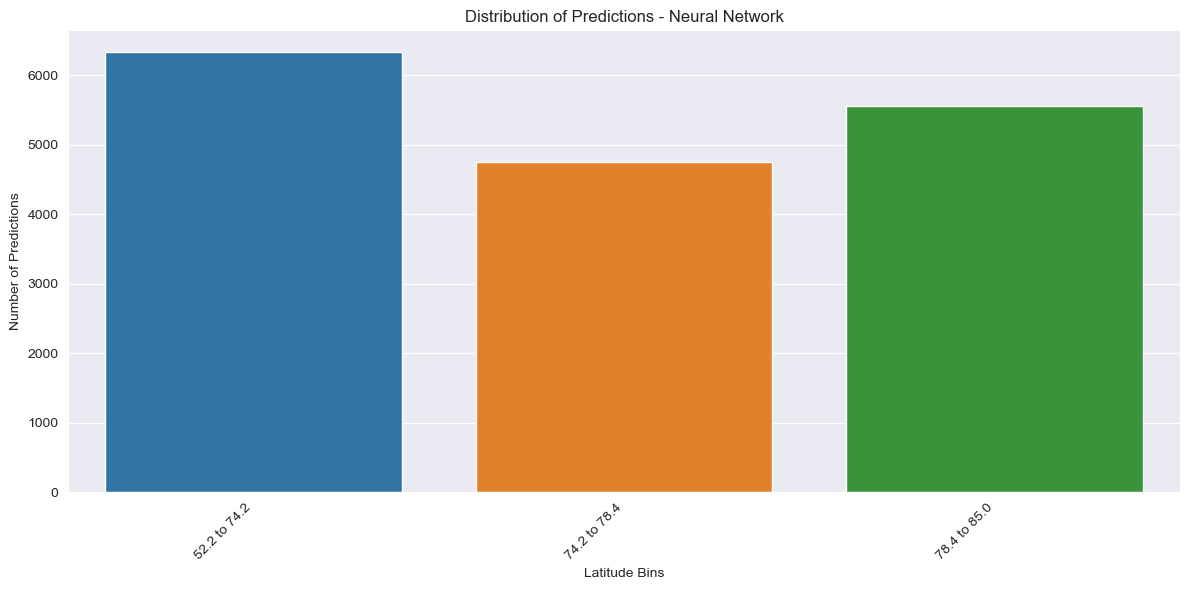

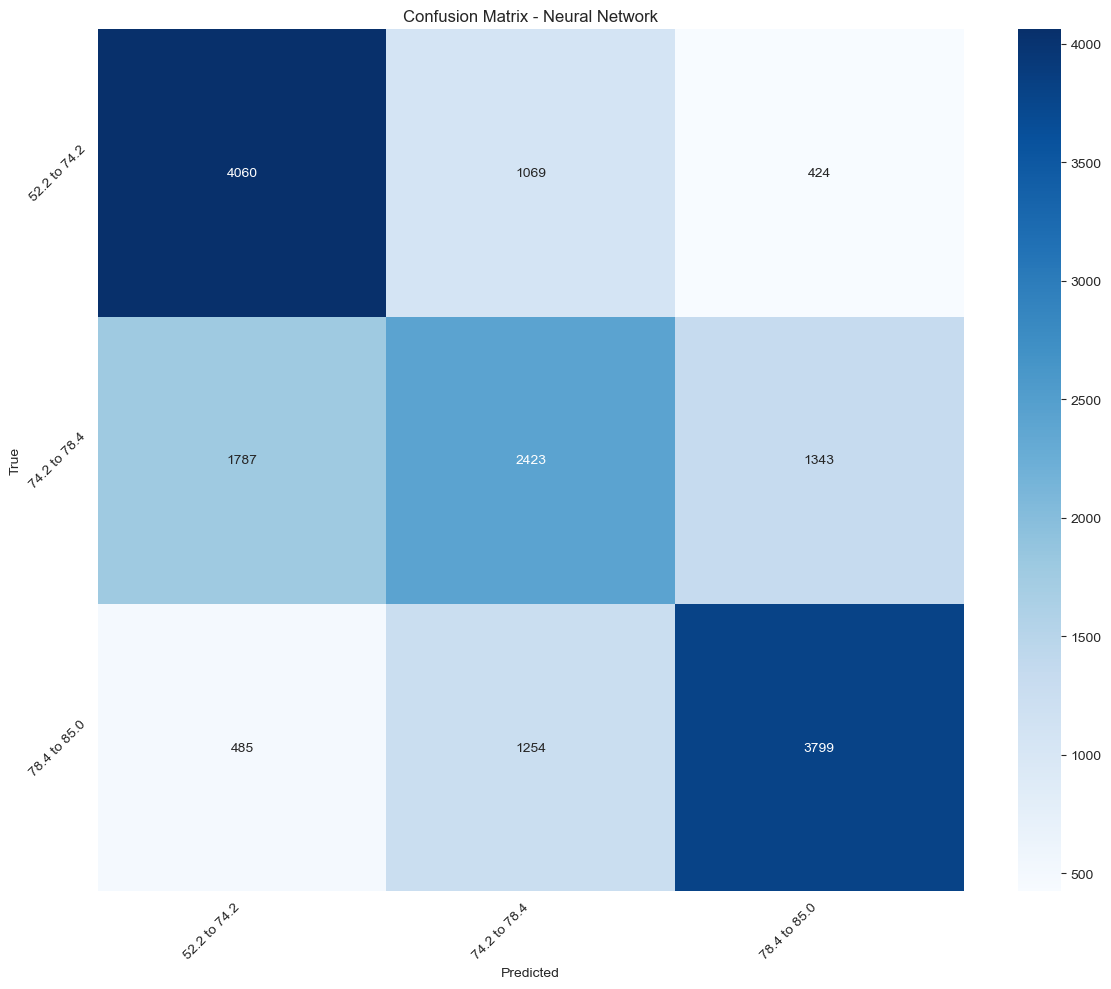

521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step


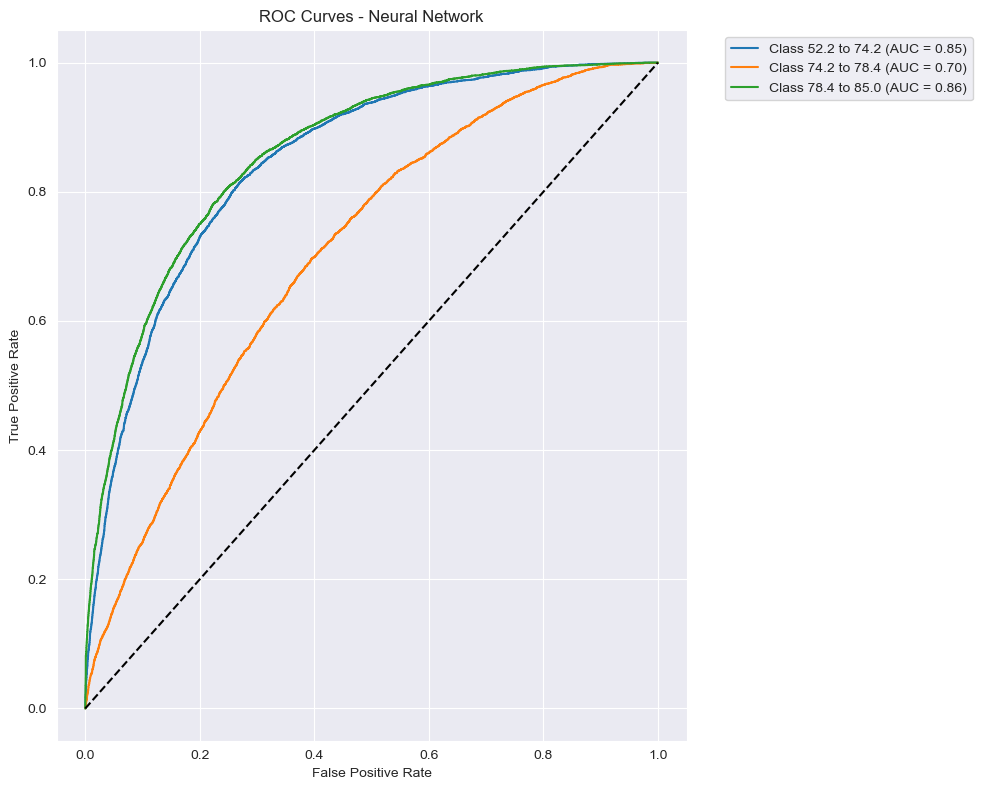


Neural Network Classification Report:
              precision    recall  f1-score   support

52.2 to 74.2       0.64      0.73      0.68      5553
74.2 to 78.4       0.51      0.44      0.47      5553
78.4 to 85.0       0.68      0.69      0.68      5538

    accuracy                           0.62     16644
   macro avg       0.61      0.62      0.61     16644
weighted avg       0.61      0.62      0.61     16644



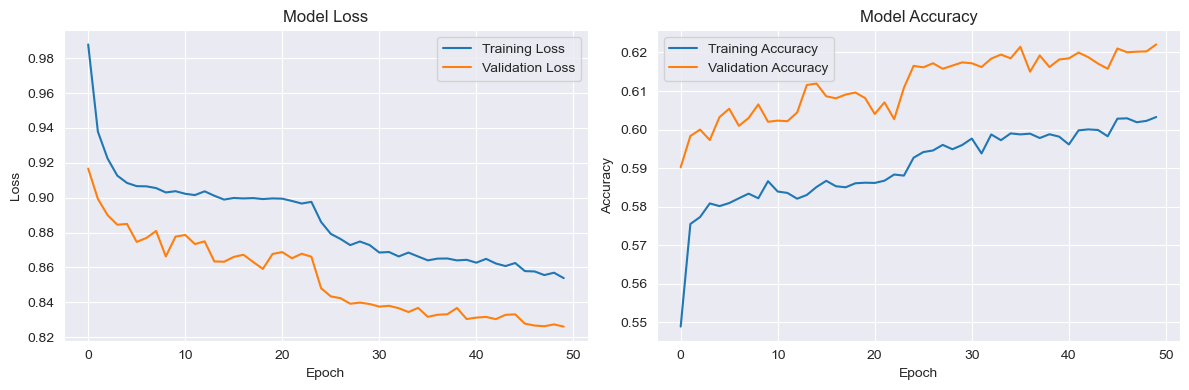

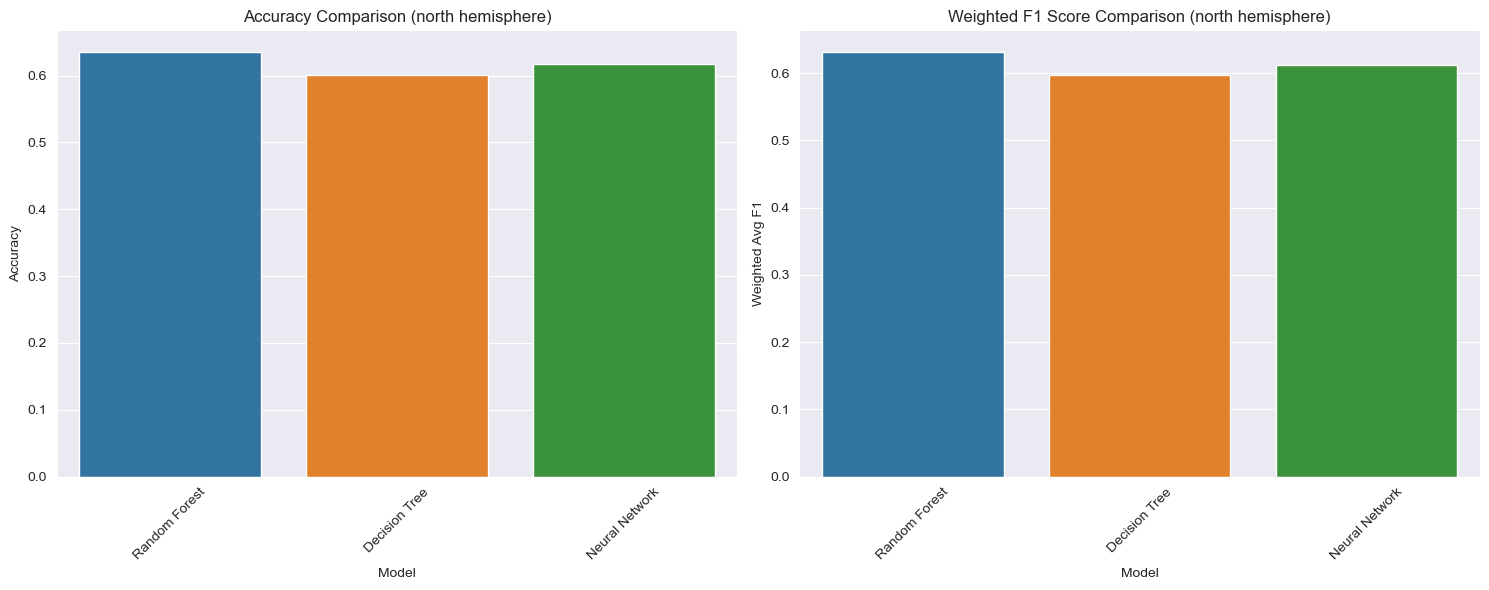


North Hemisphere Results:
            Model  Accuracy  Macro Avg F1  Weighted Avg F1
0   Random Forest  0.635845      0.632021         0.631955
1   Decision Tree  0.600397      0.597270         0.597200
2  Neural Network  0.617760      0.612668         0.612603

Training South Hemisphere Models...


/Users/beastxgamer/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1500 with 0 Axes>

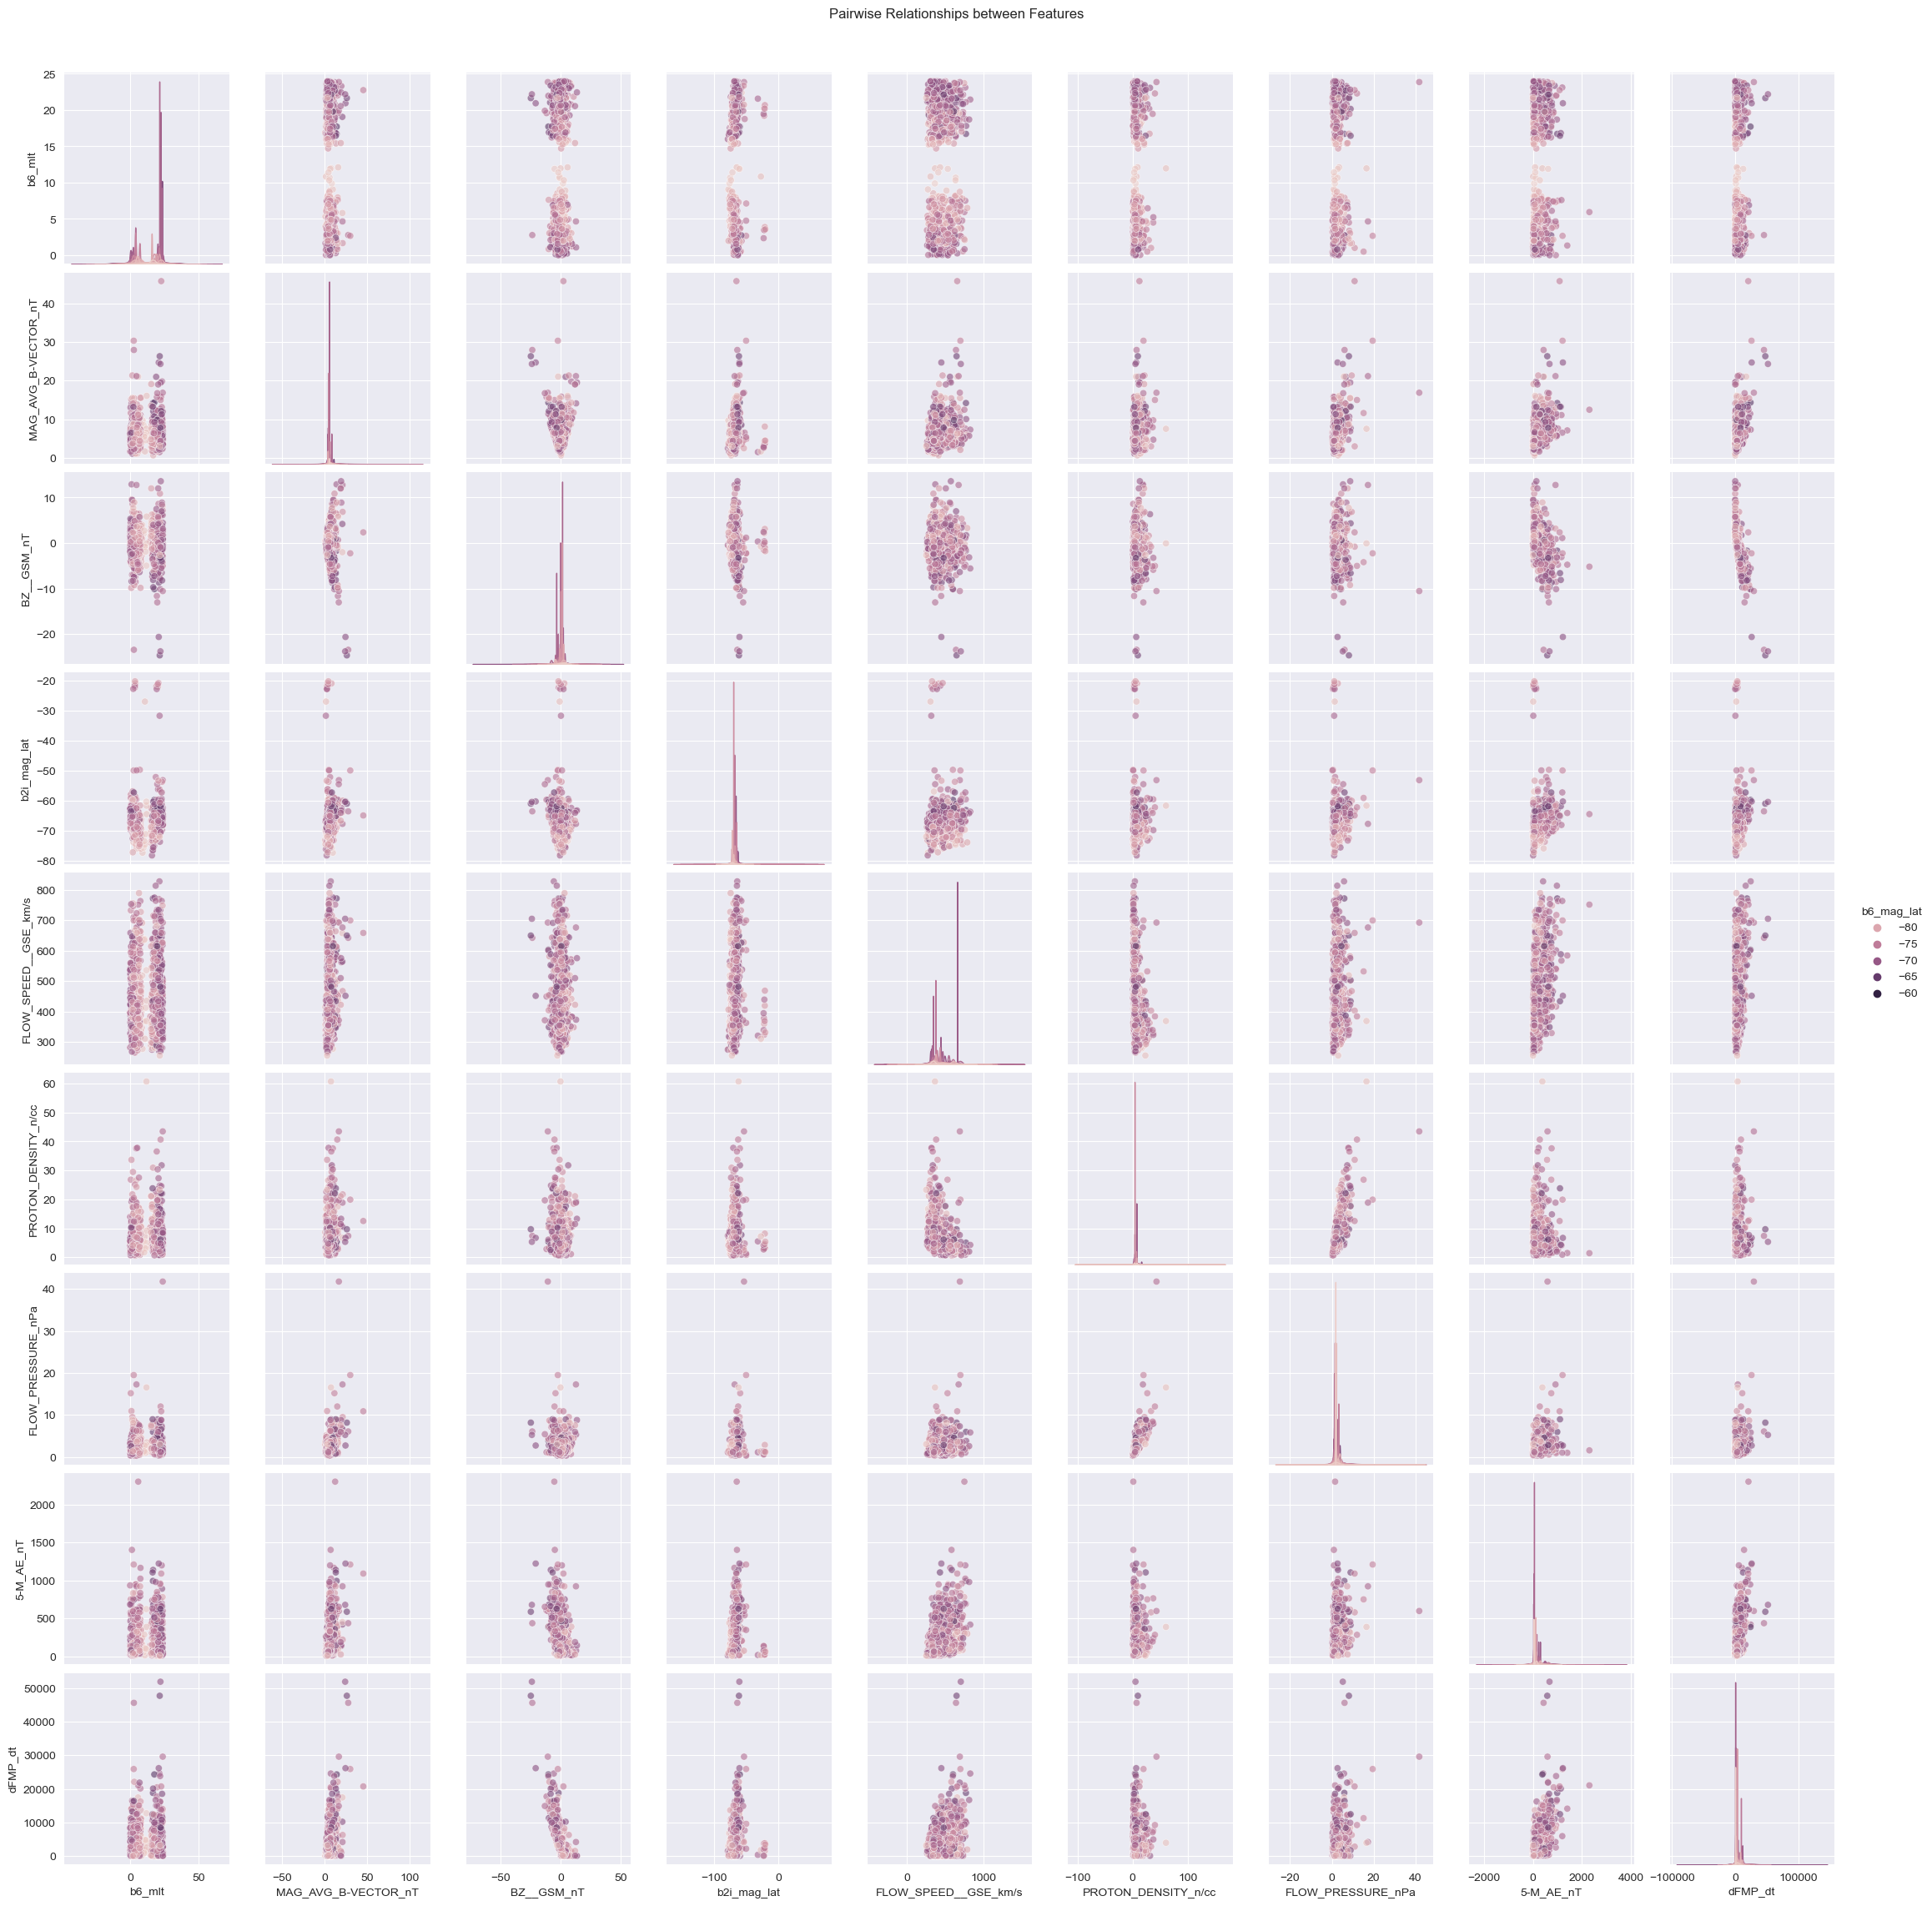


Training Random Forest...


/Users/beastxgamer/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


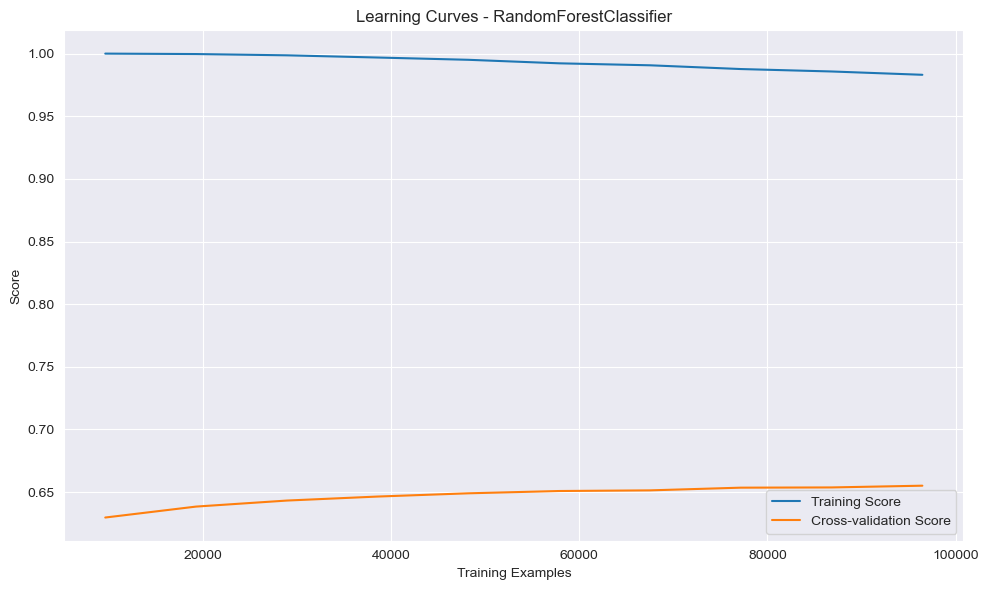

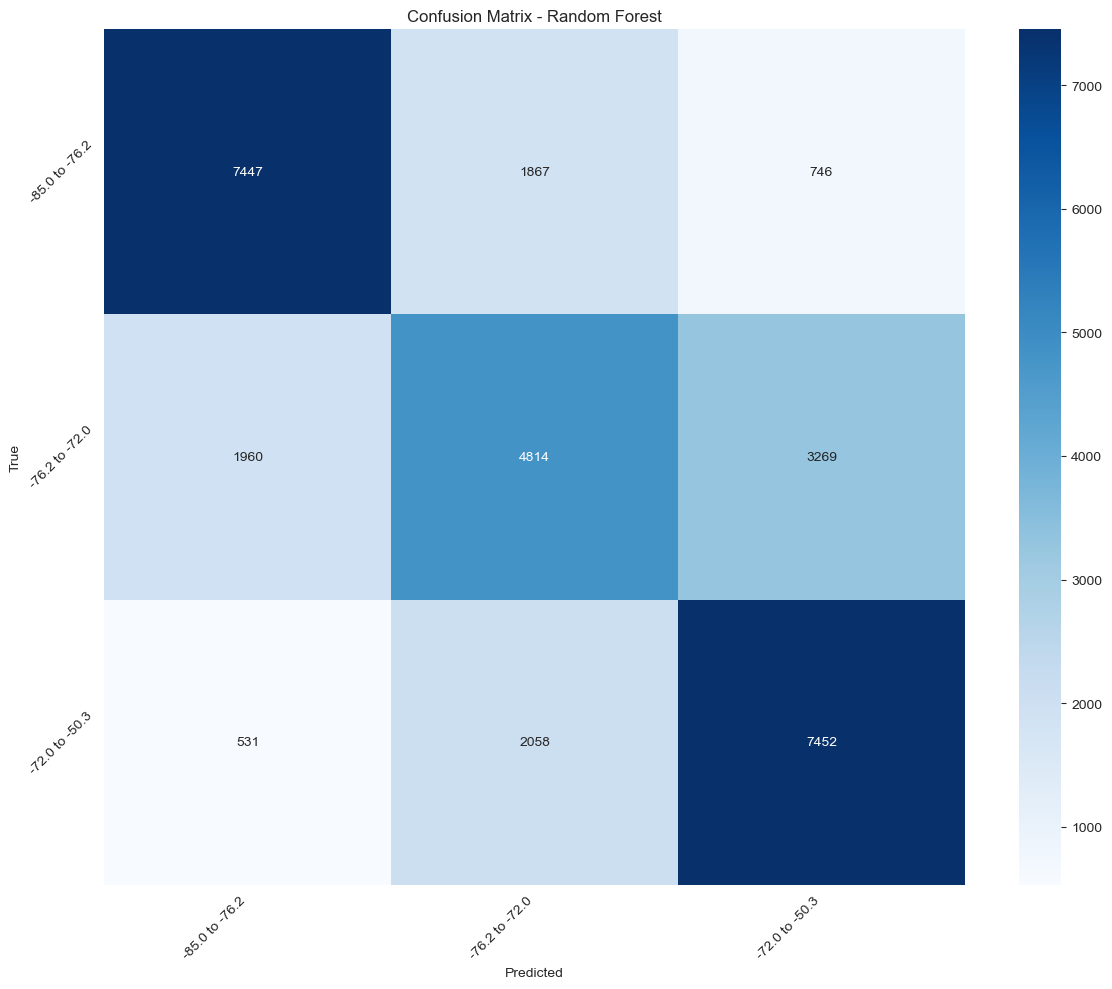

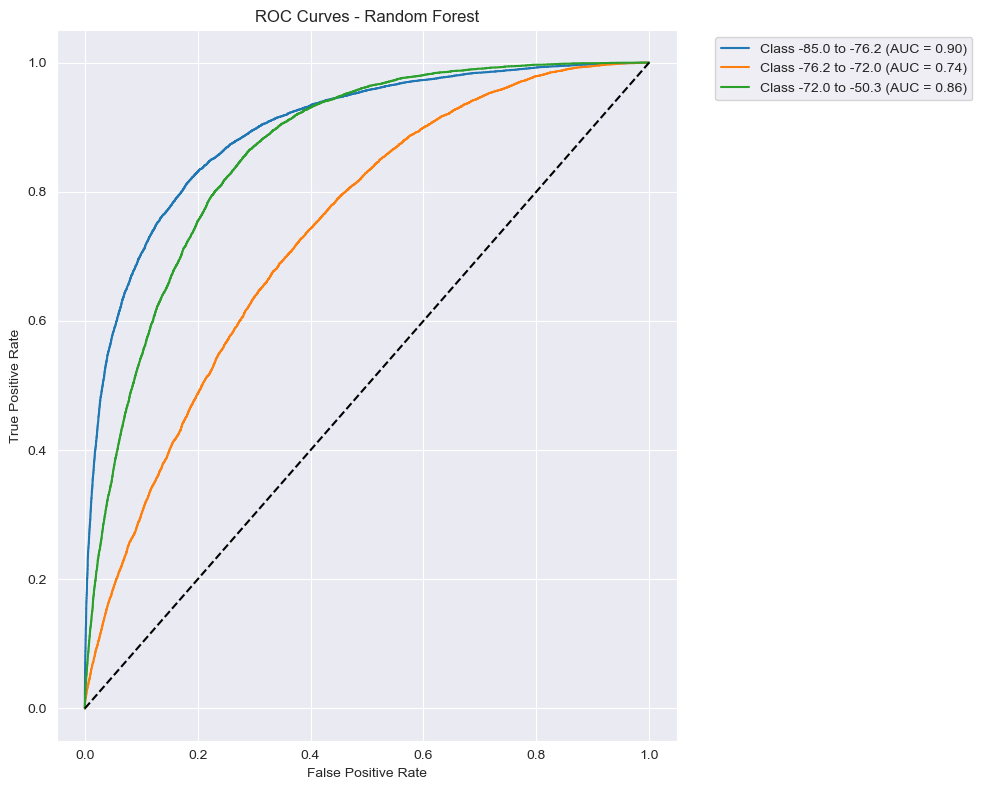

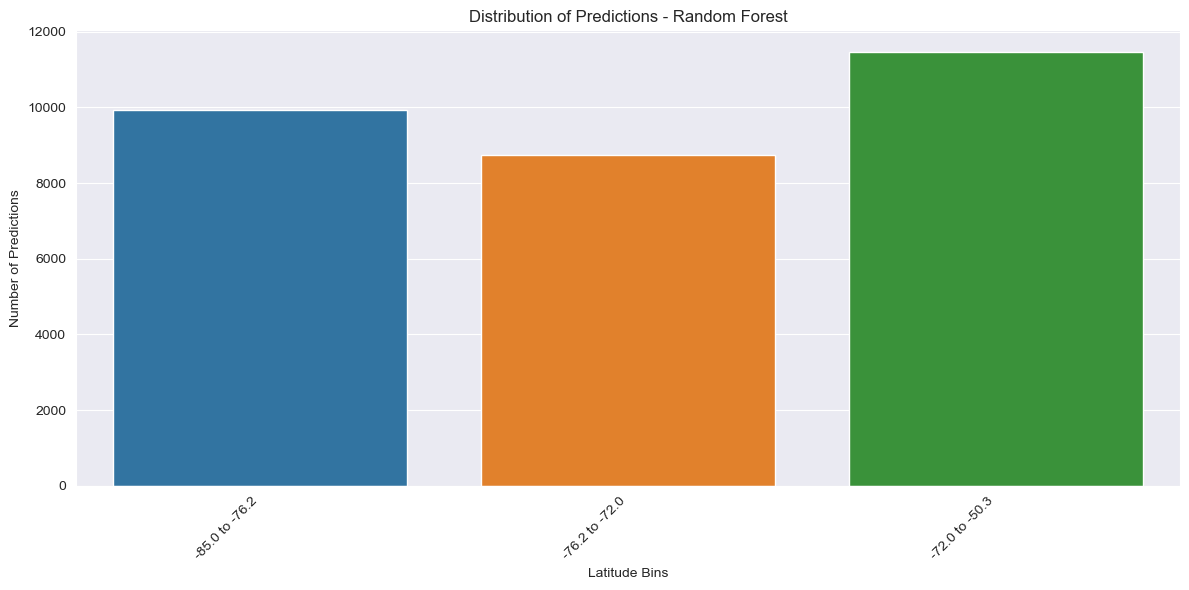

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Classification Report:
                precision    recall  f1-score   support

-85.0 to -76.2       0.75      0.74      0.74     10060
-76.2 to -72.0       0.55      0.48      0.51     10043
-72.0 to -50.3       0.65      0.74      0.69     10041

      accuracy                           0.65     30144
     macro avg       0.65      0.65      0.65     30144
  weighted avg       0.65      0.65      0.65     30144


Training Decision Tree...


/Users/beastxgamer/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


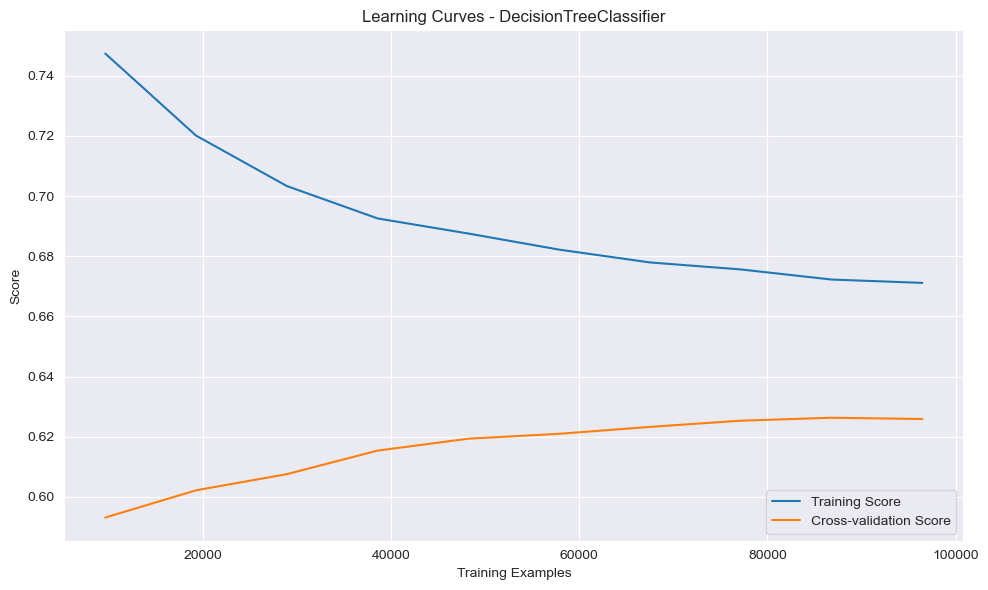

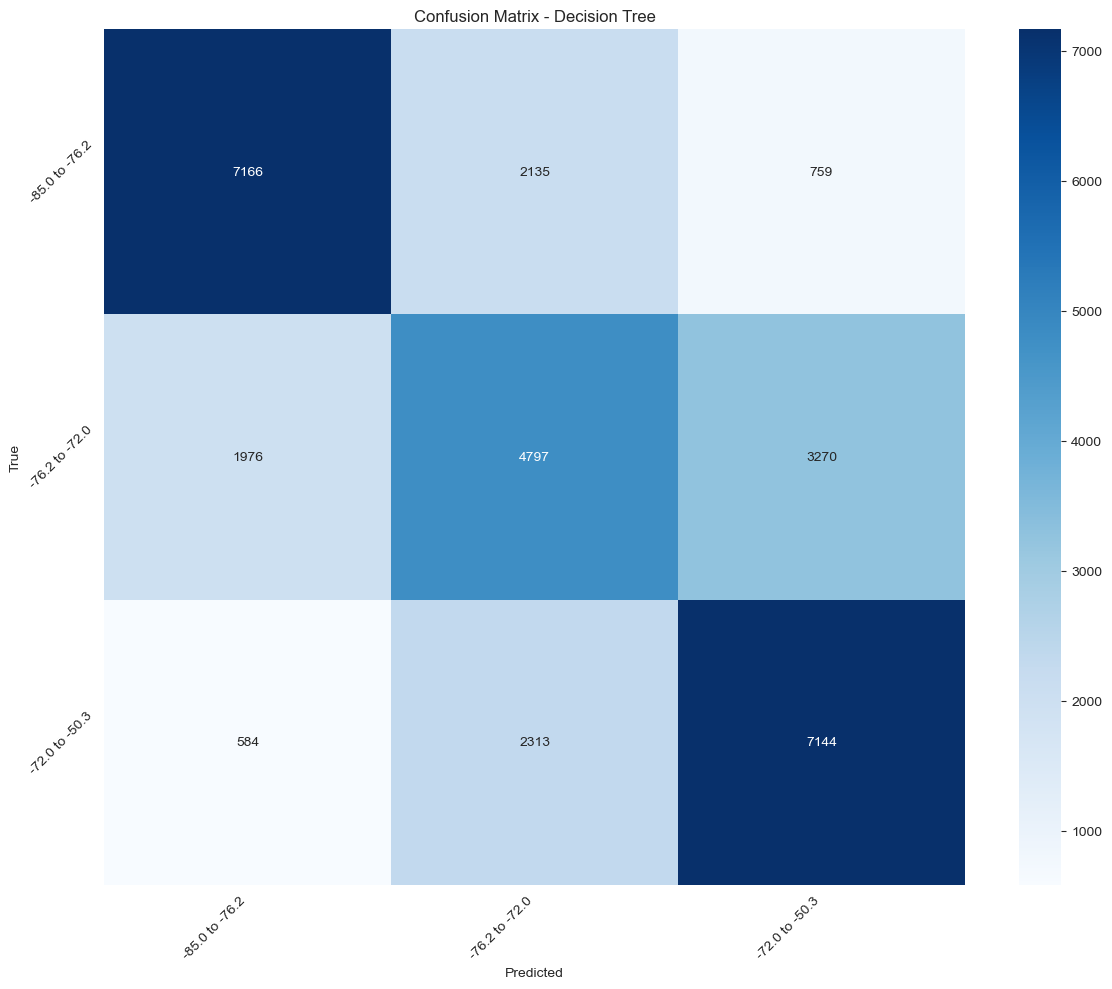

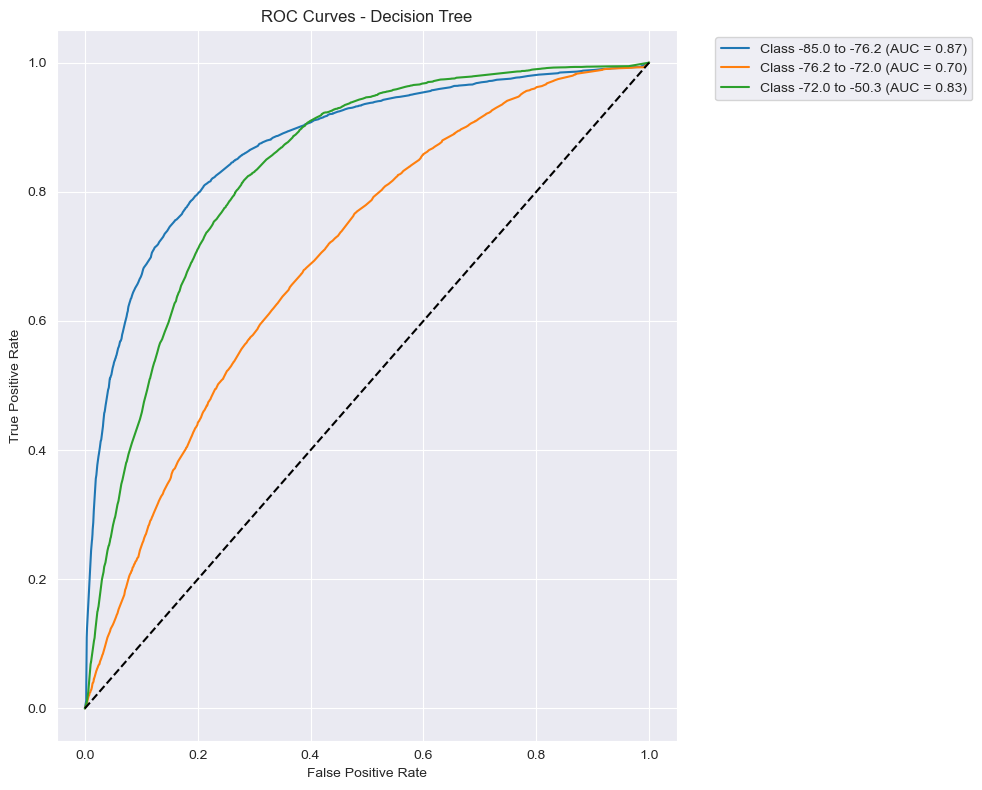

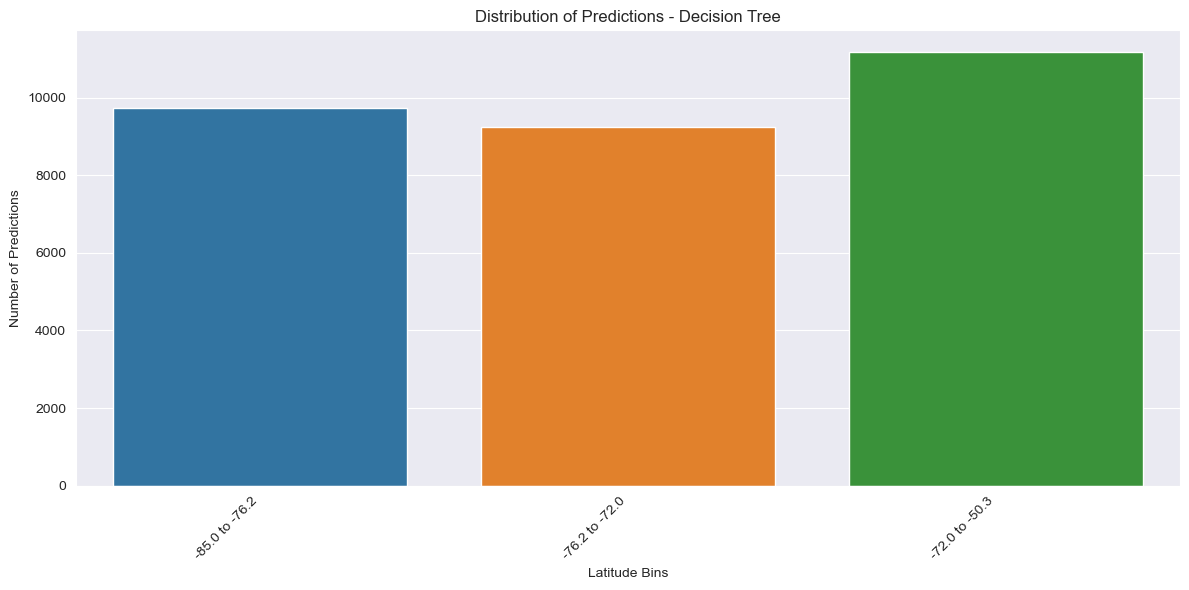

Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 5}

Classification Report:
                precision    recall  f1-score   support

-85.0 to -76.2       0.74      0.71      0.72     10060
-76.2 to -72.0       0.52      0.48      0.50     10043
-72.0 to -50.3       0.64      0.71      0.67     10041

      accuracy                           0.63     30144
     macro avg       0.63      0.63      0.63     30144
  weighted avg       0.63      0.63      0.63     30144



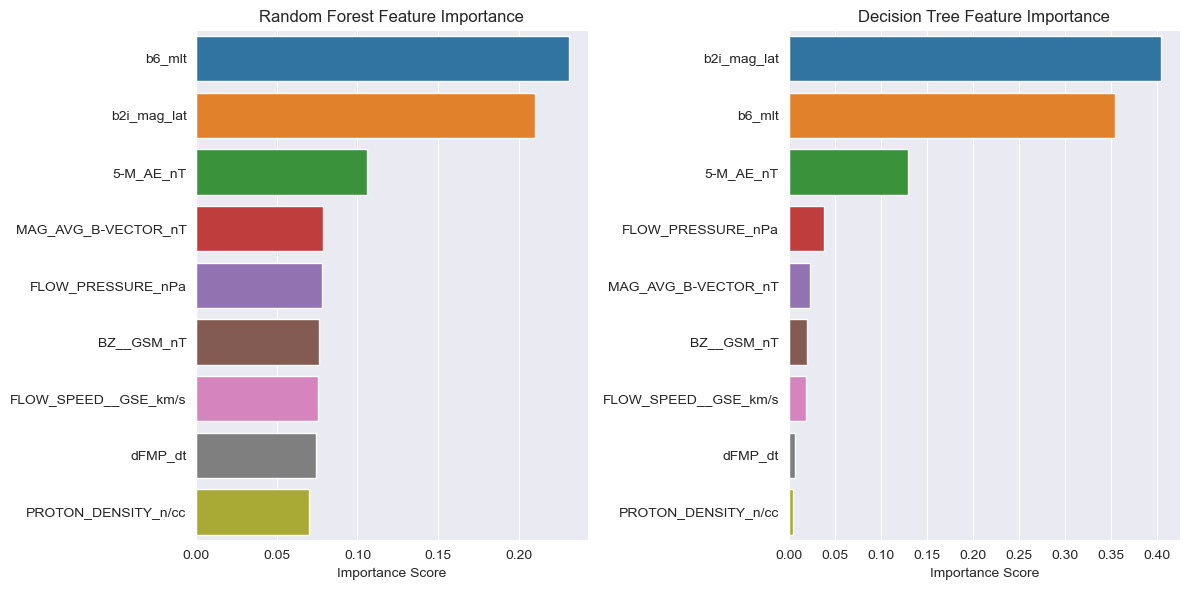


Training Neural Network...
Epoch 1/50
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5414 - loss: 1.0103 - val_accuracy: 0.6213 - val_loss: 0.8496 - learning_rate: 0.0010
Epoch 2/50
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5922 - loss: 0.8946 - val_accuracy: 0.6330 - val_loss: 0.8471 - learning_rate: 0.0010
Epoch 3/50
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5987 - loss: 0.8795 - val_accuracy: 0.6257 - val_loss: 0.8333 - learning_rate: 0.0010
Epoch 4/50
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6033 - loss: 0.8644 - val_accuracy: 0.6301 - val_loss: 0.8360 - learning_rate: 0.0010
Epoch 5/50
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6075 - loss: 0.8643 - val_accuracy: 0.6301 - val_loss: 0.8313 - learning_rate: 0.0010
Epoch 6/50
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6114 - loss: 0.8579 - val_accuracy: 0.6383 - val_loss: 0.8168 - learning_rate: 0.0010
Epoch 7/50
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms

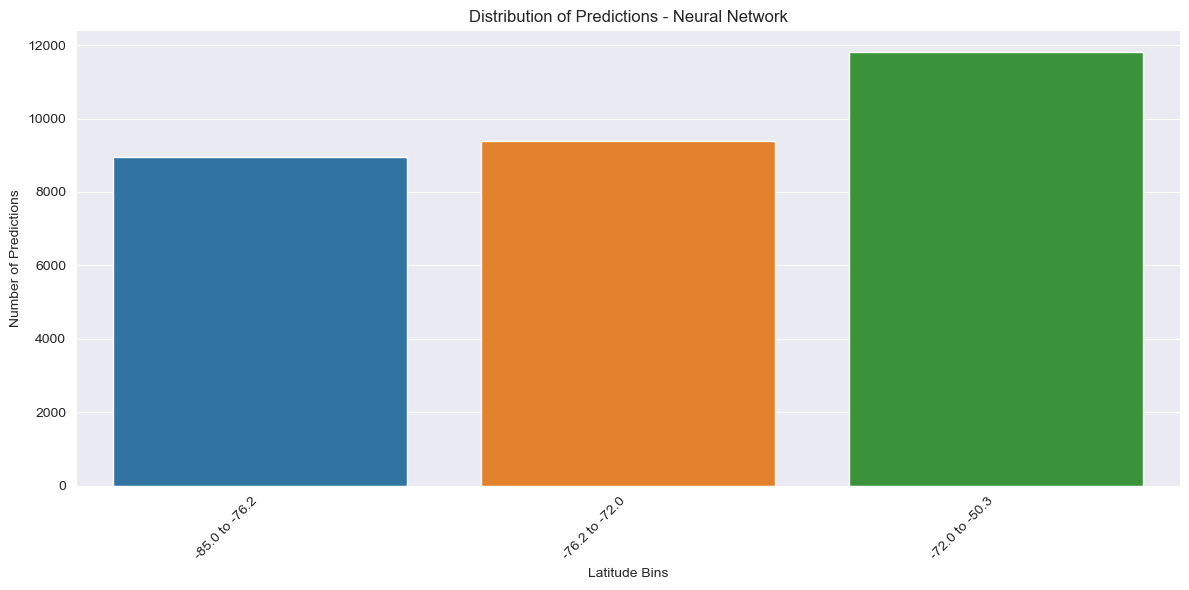

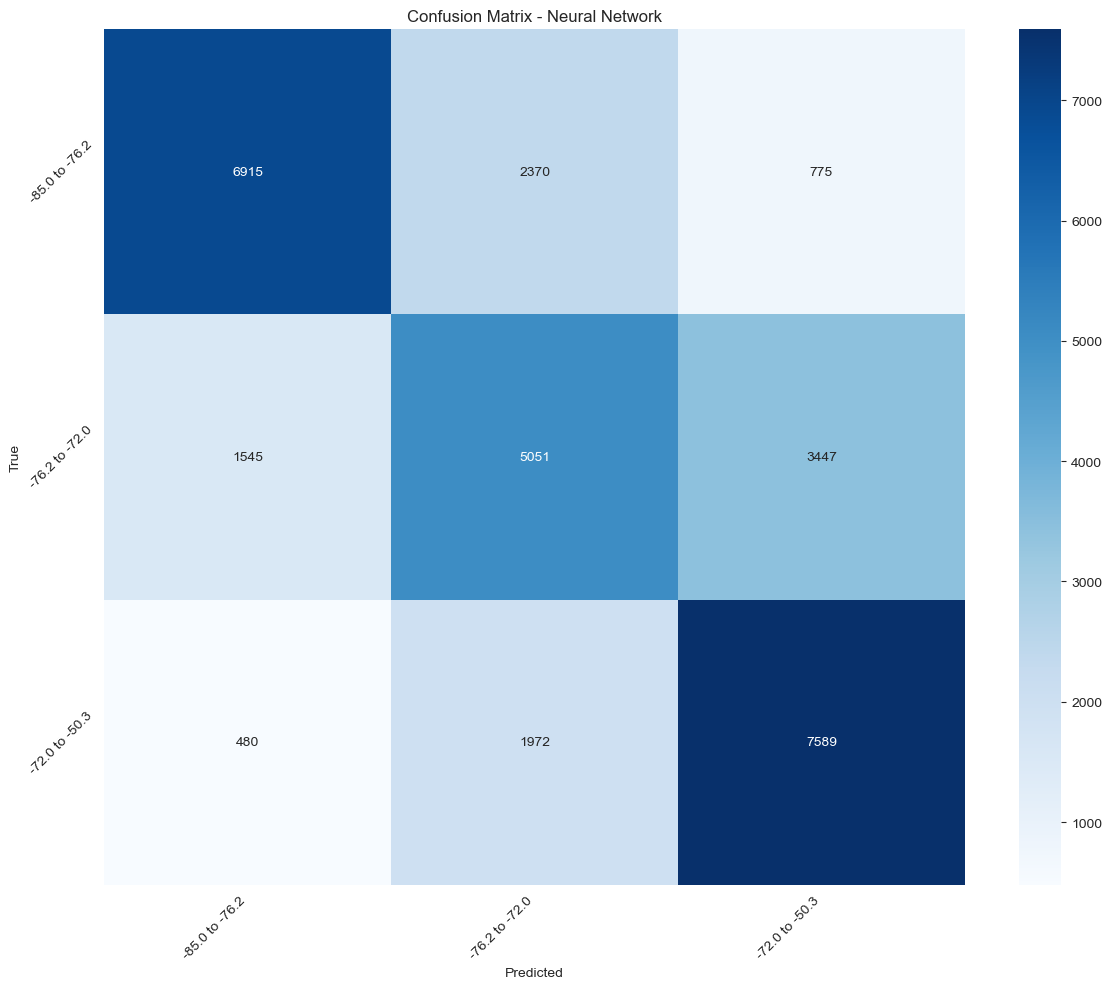

942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step


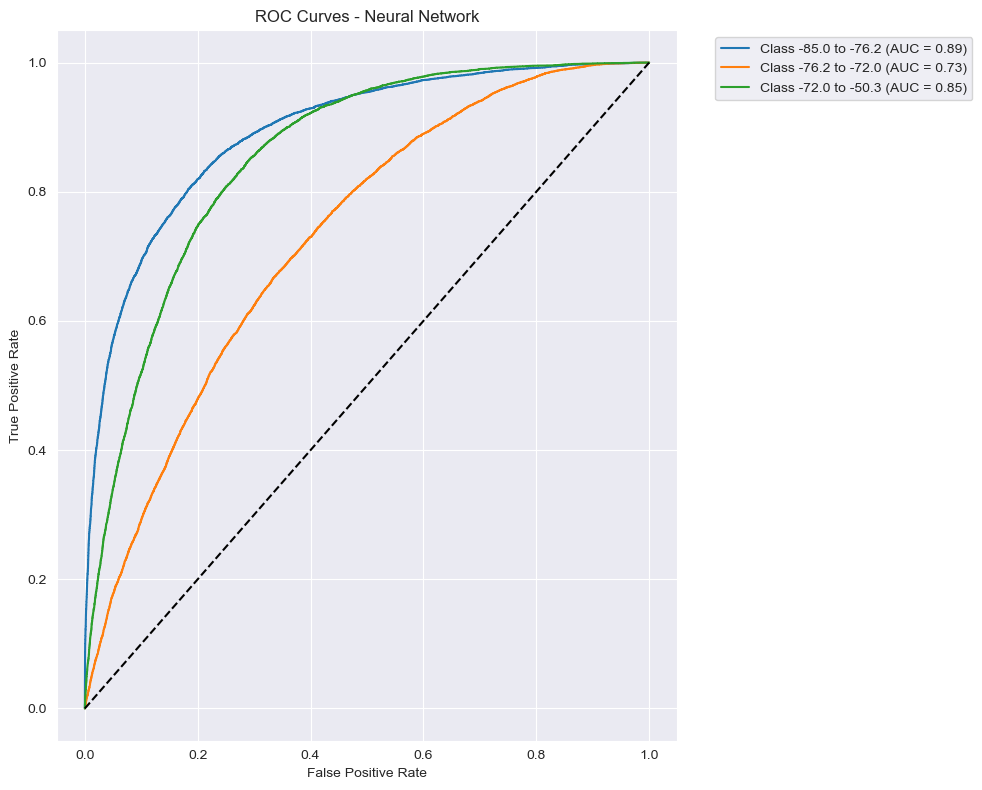


Neural Network Classification Report:
                precision    recall  f1-score   support

-85.0 to -76.2       0.77      0.69      0.73     10060
-76.2 to -72.0       0.54      0.50      0.52     10043
-72.0 to -50.3       0.64      0.76      0.69     10041

      accuracy                           0.65     30144
     macro avg       0.65      0.65      0.65     30144
  weighted avg       0.65      0.65      0.65     30144



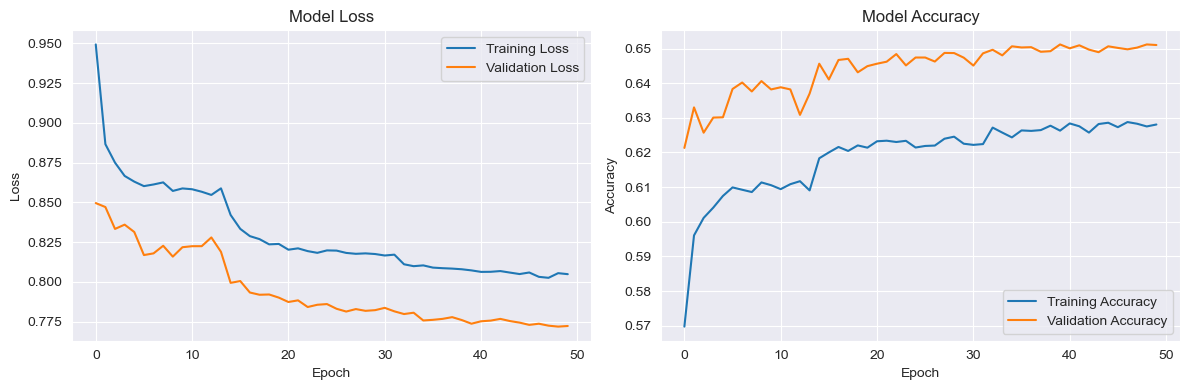

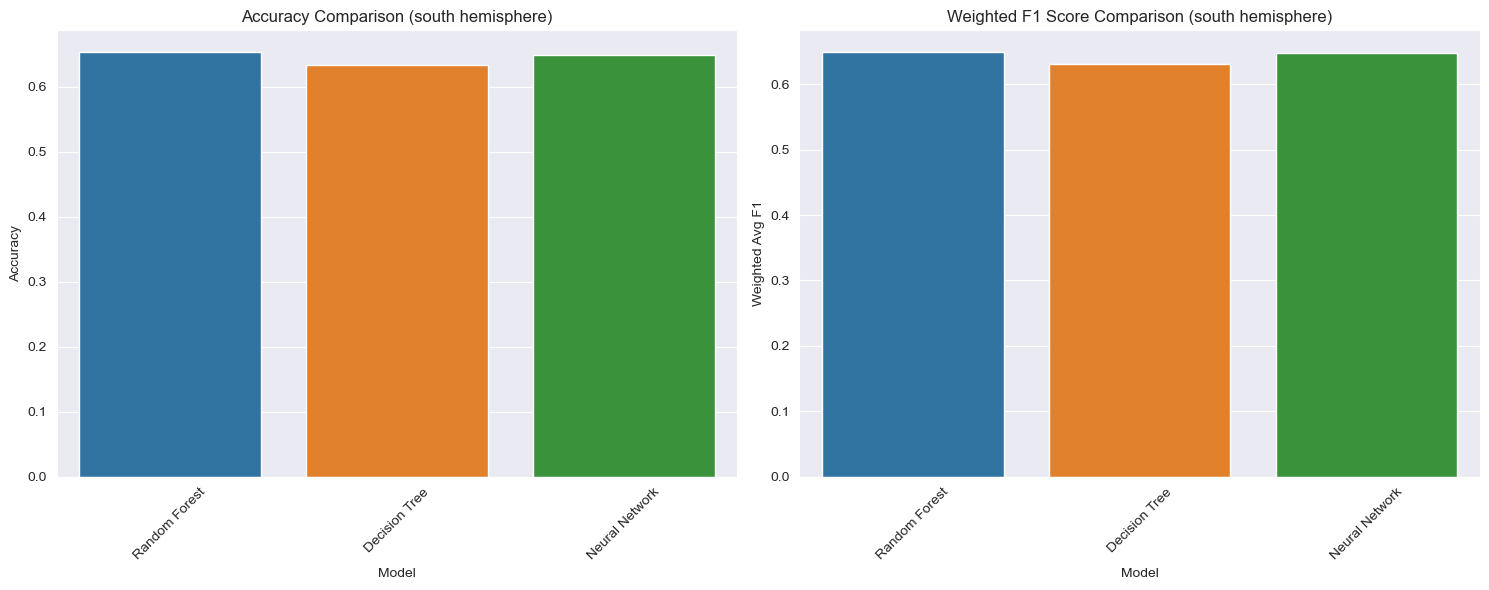


South Hemisphere Results:
            Model  Accuracy  Macro Avg F1  Weighted Avg F1
0   Random Forest  0.653961      0.650115         0.650165
1   Decision Tree  0.633857      0.631759         0.631808
2  Neural Network  0.648719      0.647411         0.647453


In [9]:
# Nightside Testing #
# changeable features and target
features_nightside = [
    'b6_mlt', 
    'MAG_AVG_B-VECTOR_nT', 
    'BZ__GSM_nT',
    'b2i_mag_lat',
    'FLOW_SPEED__GSE_km/s',
    'PROTON_DENSITY_n/cc', 
    'FLOW_PRESSURE_nPa', 
    '5-M_AE_nT', 
    'dFMP_dt'
]
target_nightside = 'b6_mag_lat'

print("Training North Hemisphere Models...")
north_results, north_models, north_scaler, north_edges, north_labels, north_history = train_classification_models(nightsideN_df, features_nightside, target_nightside, 'north', n_bins=3)
print("\nNorth Hemisphere Results:")
print(north_results)

print("\nTraining South Hemisphere Models...")
south_results, south_models, south_scaler, south_edges, south_labels, south_history = train_classification_models(nightsideS_df, features_nightside, target_nightside, 'south', n_bins=3)
print("\nSouth Hemisphere Results:")
print(south_results)

Training North Hemisphere Models...


/Users/beastxgamer/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1500 with 0 Axes>

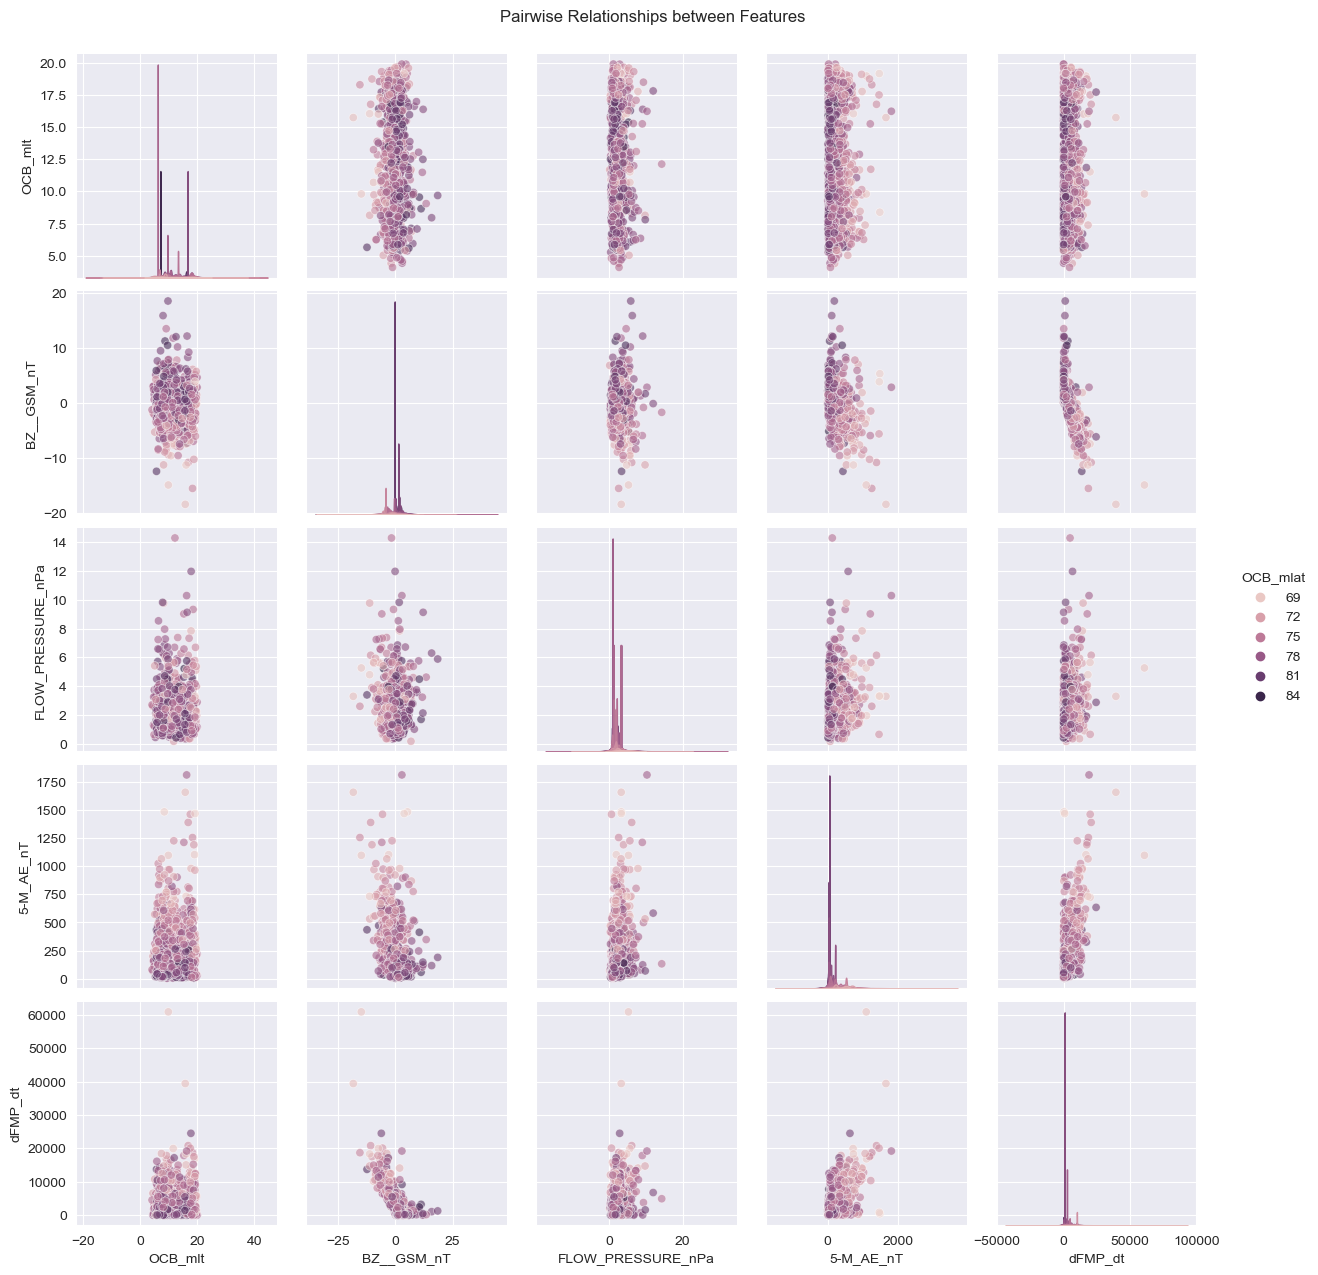


Training Random Forest...


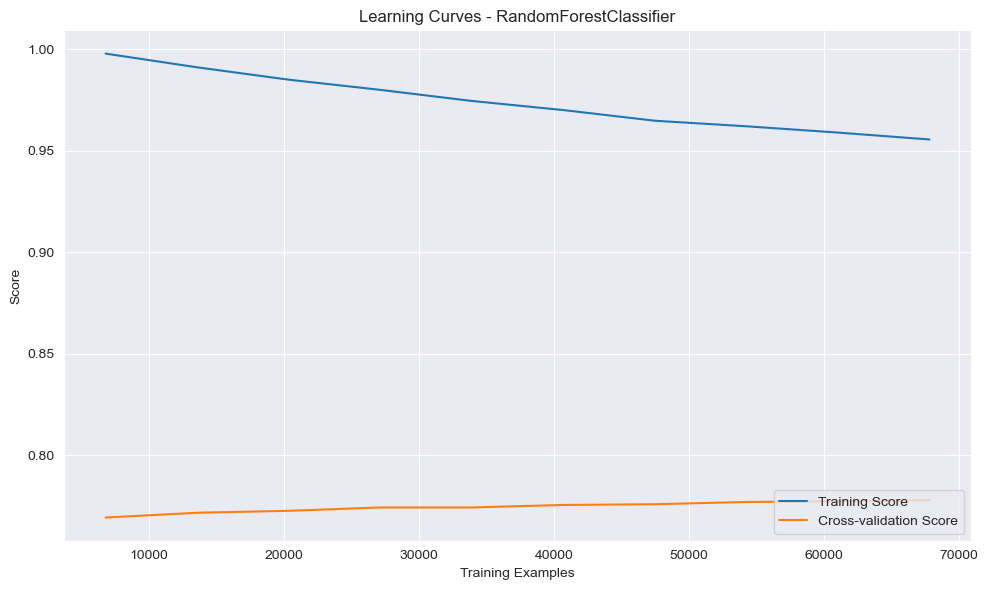

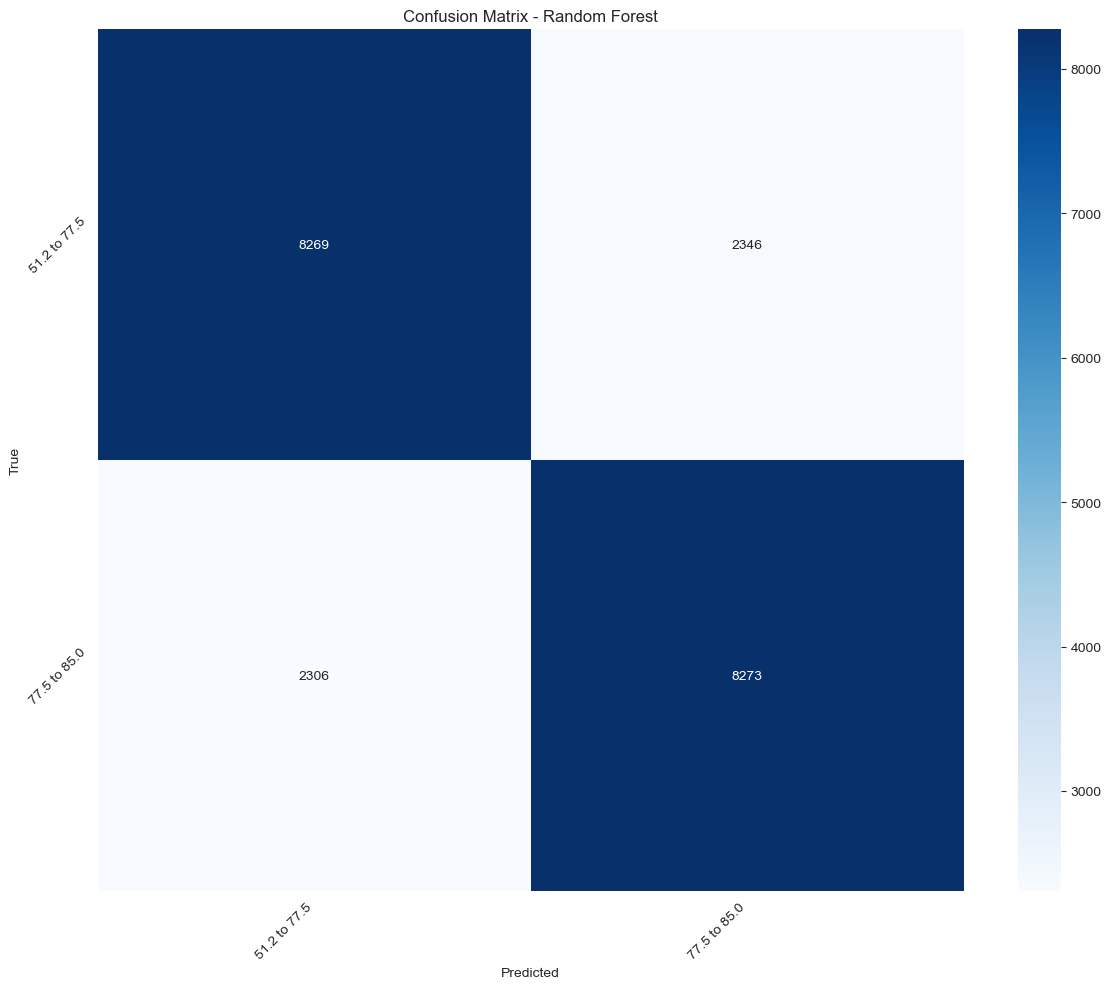

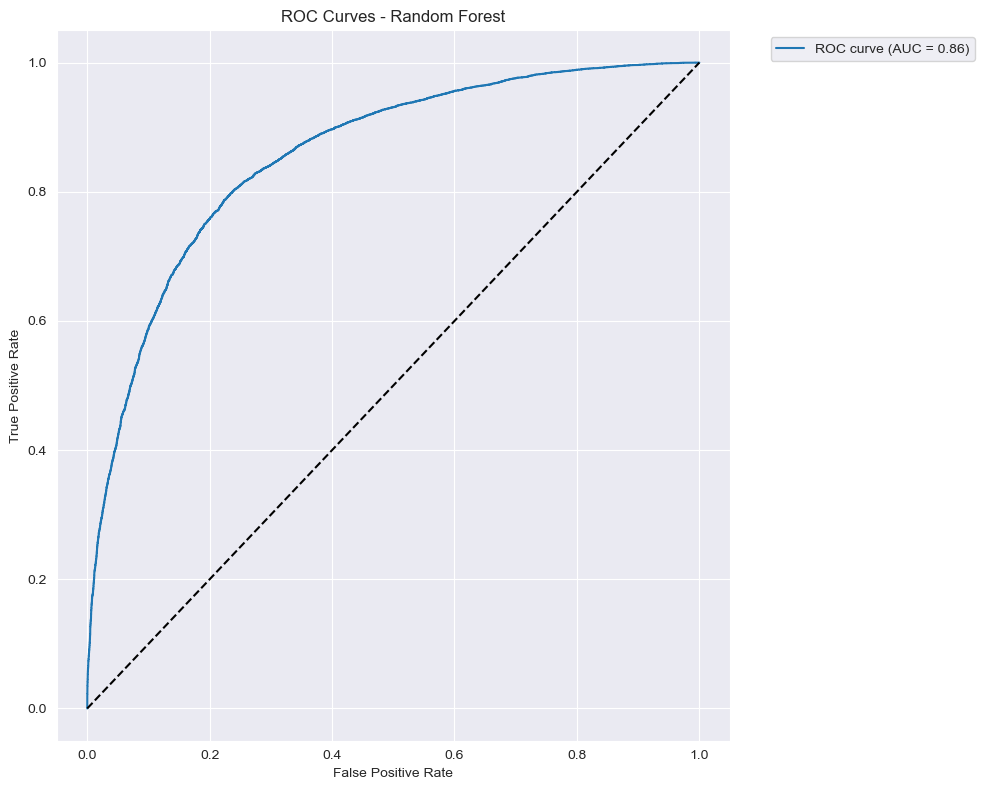

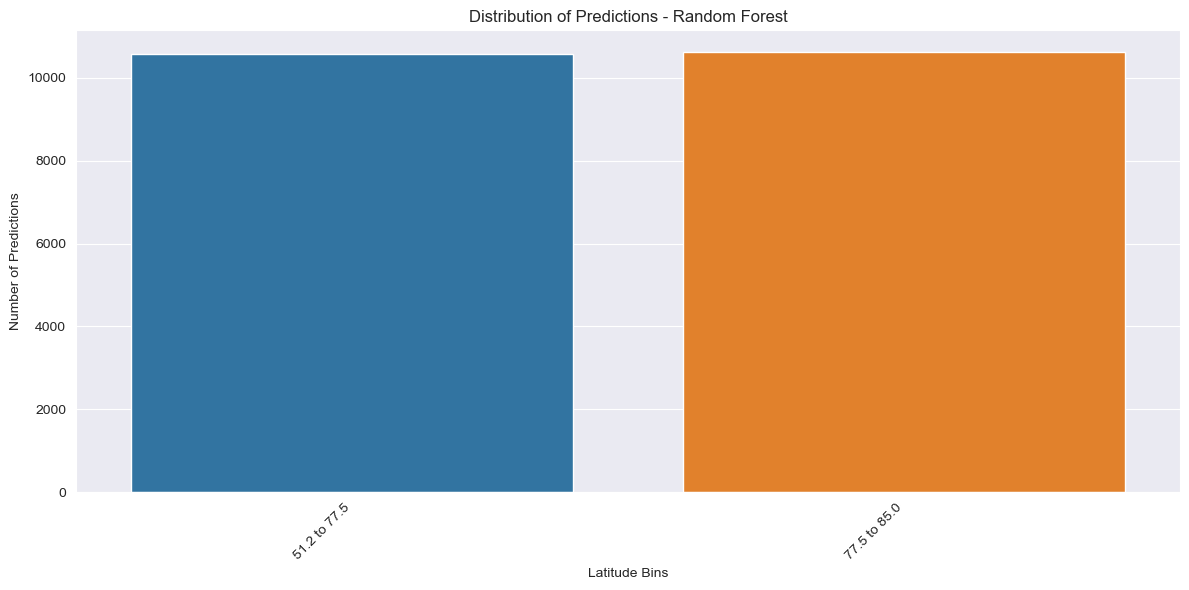

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

51.2 to 77.5       0.78      0.78      0.78     10615
77.5 to 85.0       0.78      0.78      0.78     10579

    accuracy                           0.78     21194
   macro avg       0.78      0.78      0.78     21194
weighted avg       0.78      0.78      0.78     21194


Training Decision Tree...


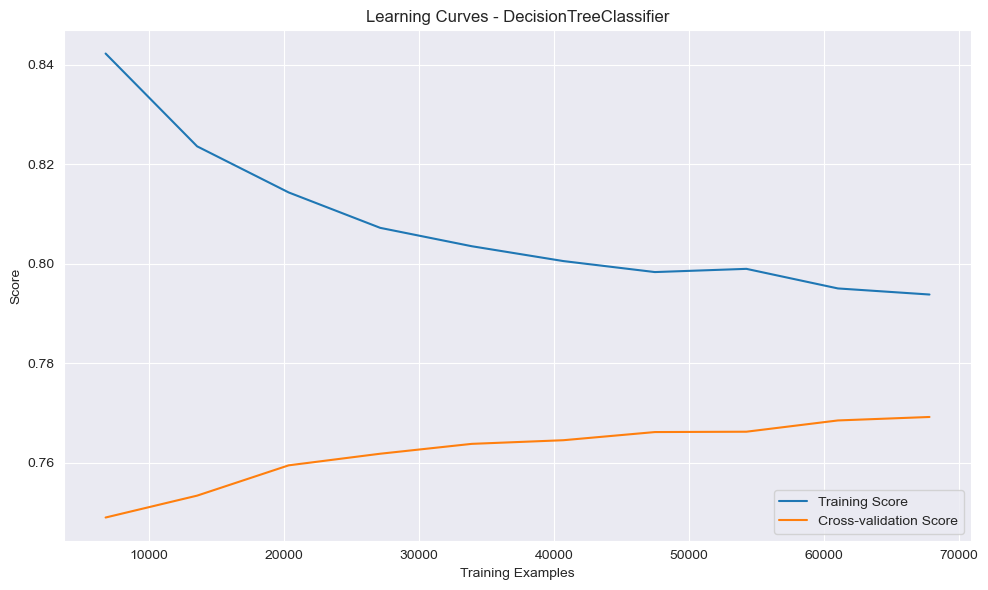

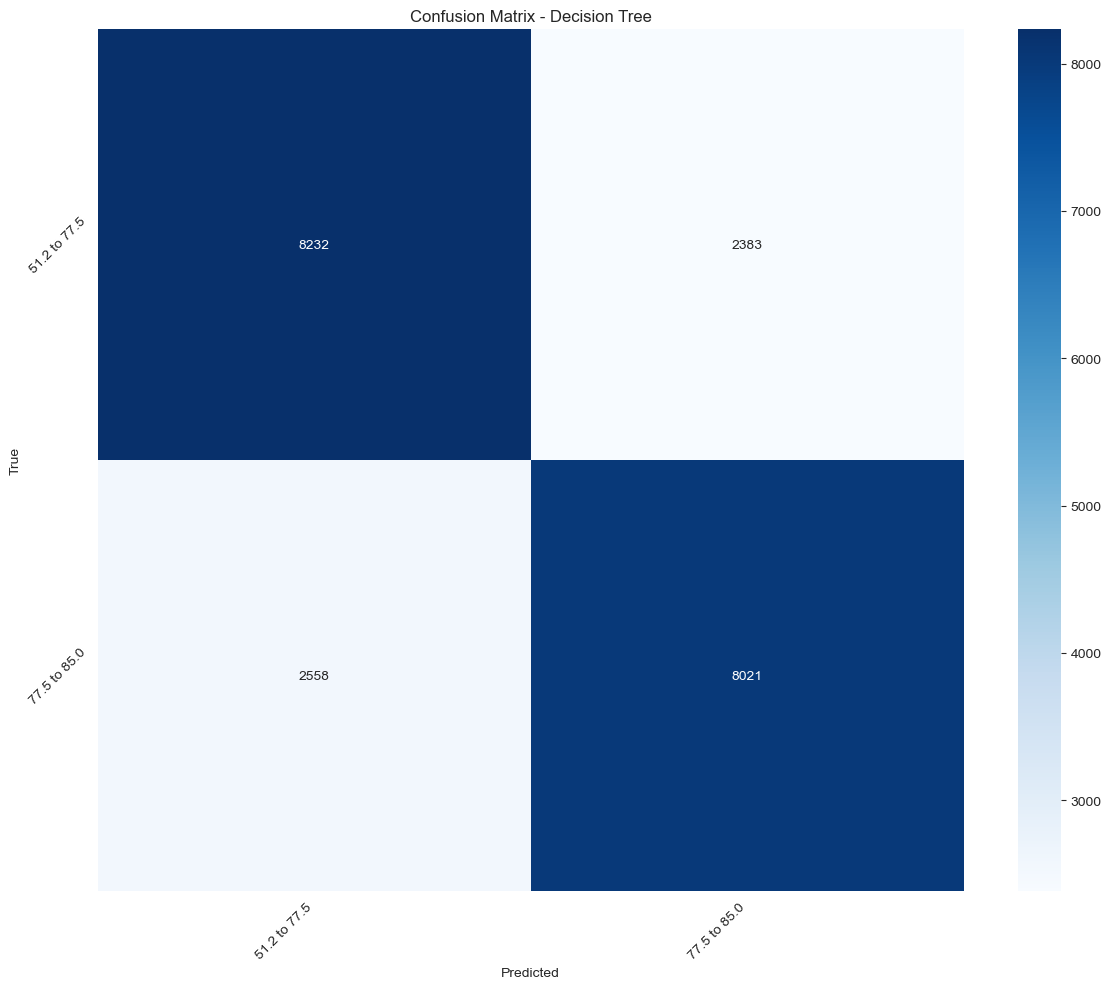

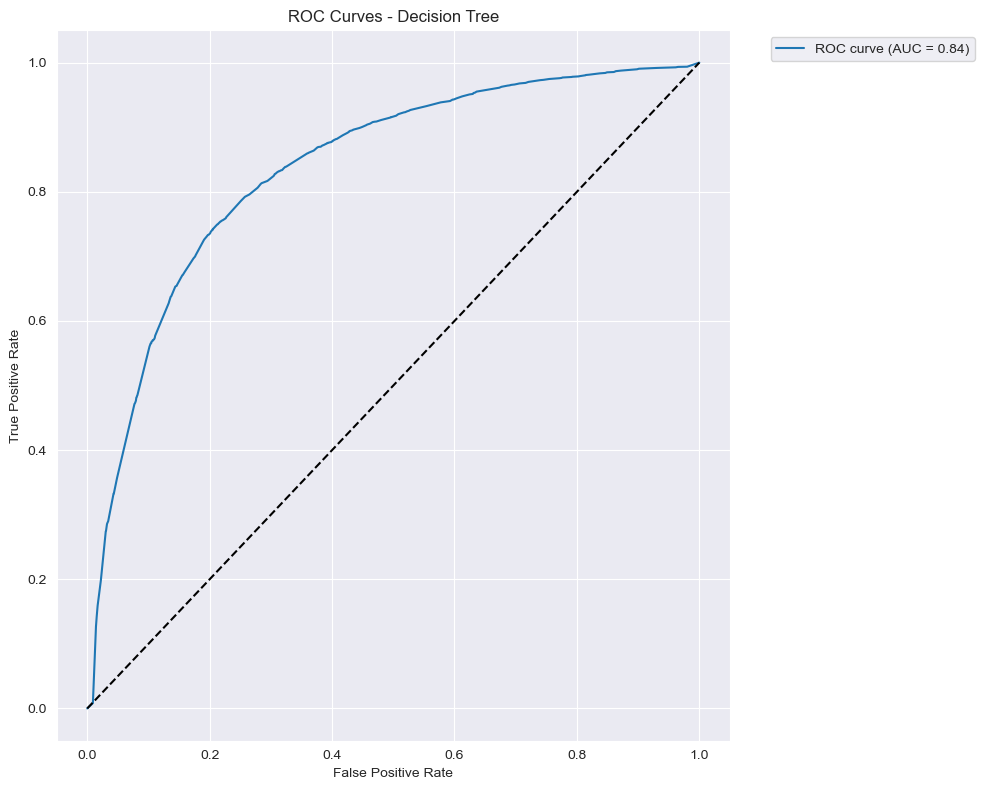

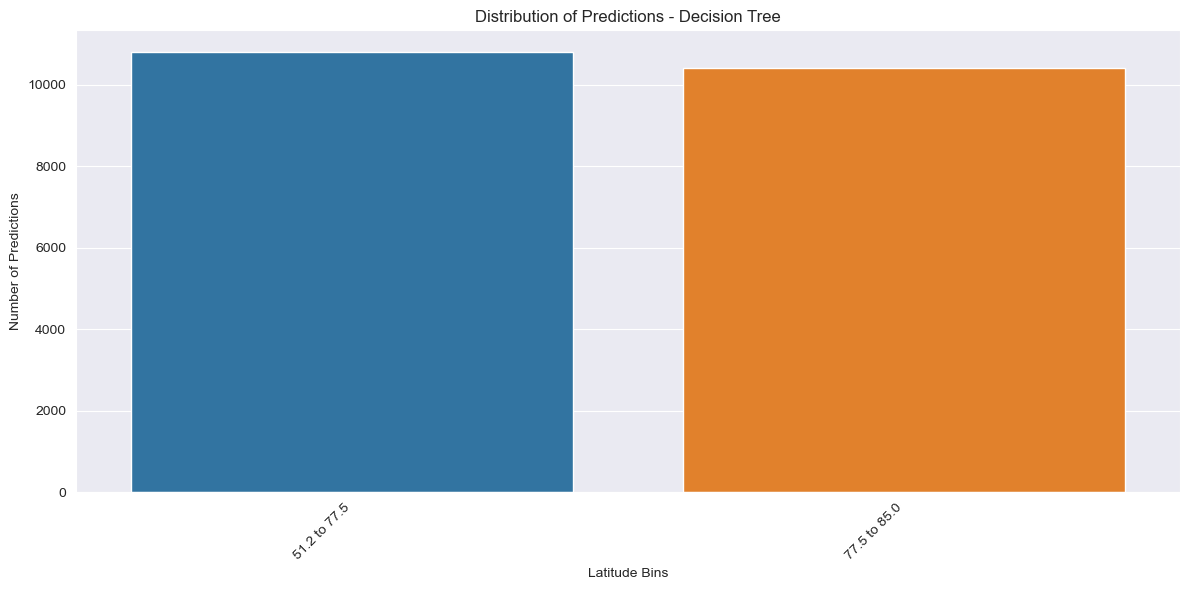

Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 5}

Classification Report:
              precision    recall  f1-score   support

51.2 to 77.5       0.76      0.78      0.77     10615
77.5 to 85.0       0.77      0.76      0.76     10579

    accuracy                           0.77     21194
   macro avg       0.77      0.77      0.77     21194
weighted avg       0.77      0.77      0.77     21194



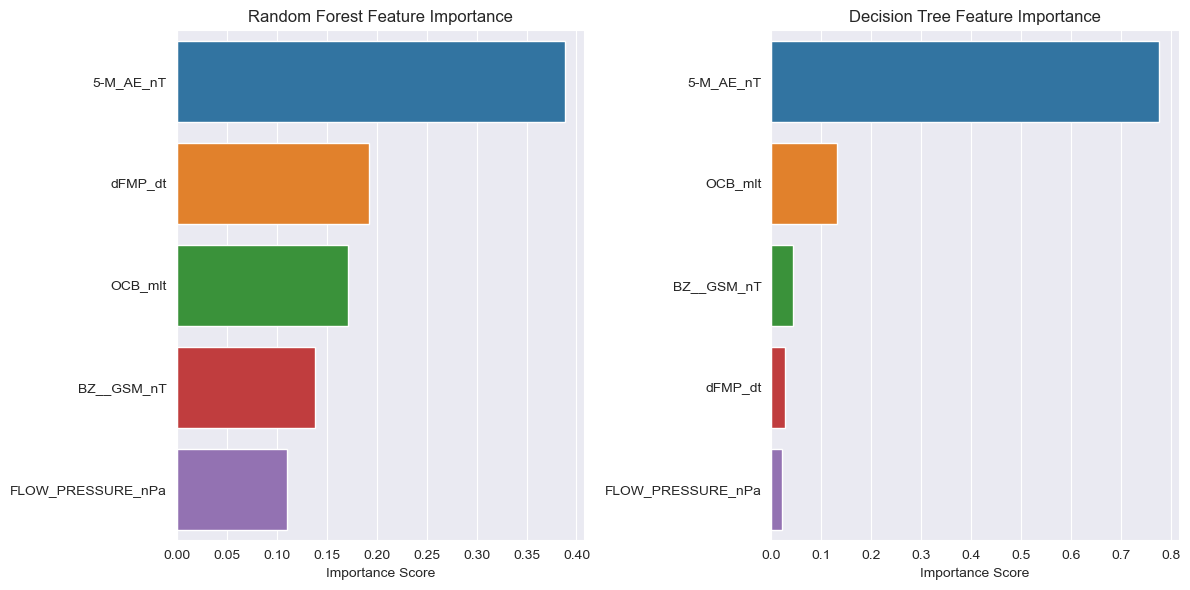


Training Neural Network...
Epoch 1/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7473 - loss: 0.5914 - val_accuracy: 0.7647 - val_loss: 0.5358 - learning_rate: 0.0010
Epoch 2/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7598 - loss: 0.5441 - val_accuracy: 0.7657 - val_loss: 0.5170 - learning_rate: 0.0010
Epoch 3/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7583 - loss: 0.5282 - val_accuracy: 0.7687 - val_loss: 0.5077 - learning_rate: 0.0010
Epoch 4/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7645 - loss: 0.5179 - val_accuracy: 0.7673 - val_loss: 0.5070 - learning_rate: 0.0010
Epoch 5/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7631 - loss: 0.5202 - val_accuracy: 0.7643 - val_loss: 0.5081 - learning_rate: 0.0010
Epoch 6/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7623 - loss: 0.5204 - val_accuracy: 0.7657 - val_loss: 0.5056 - learning_rate: 0.0010
Epoch 7/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms

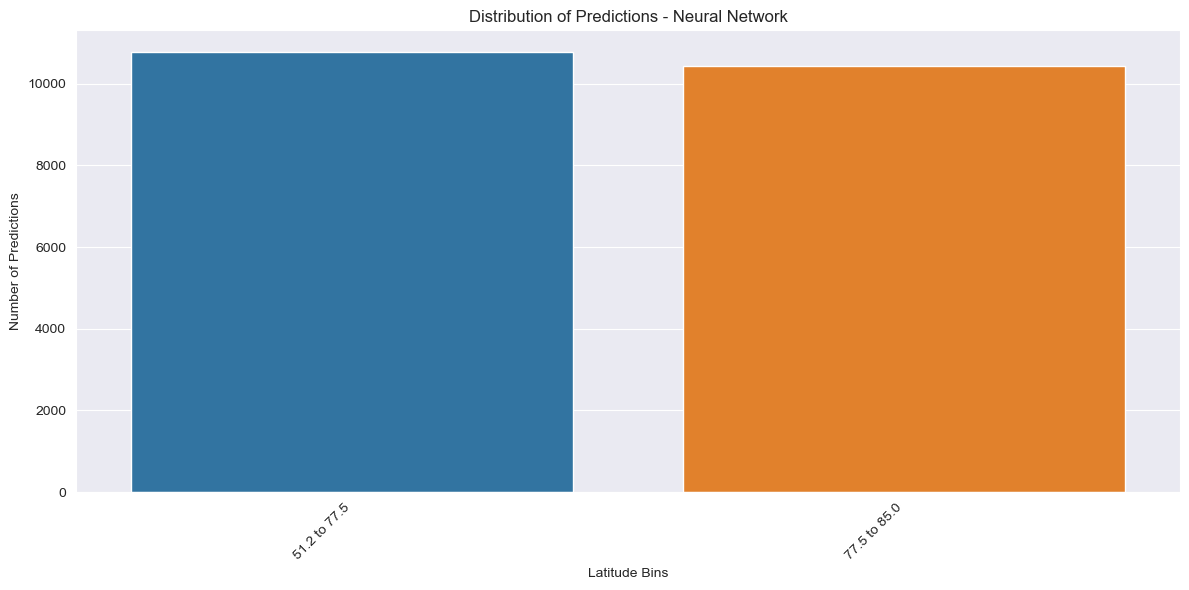

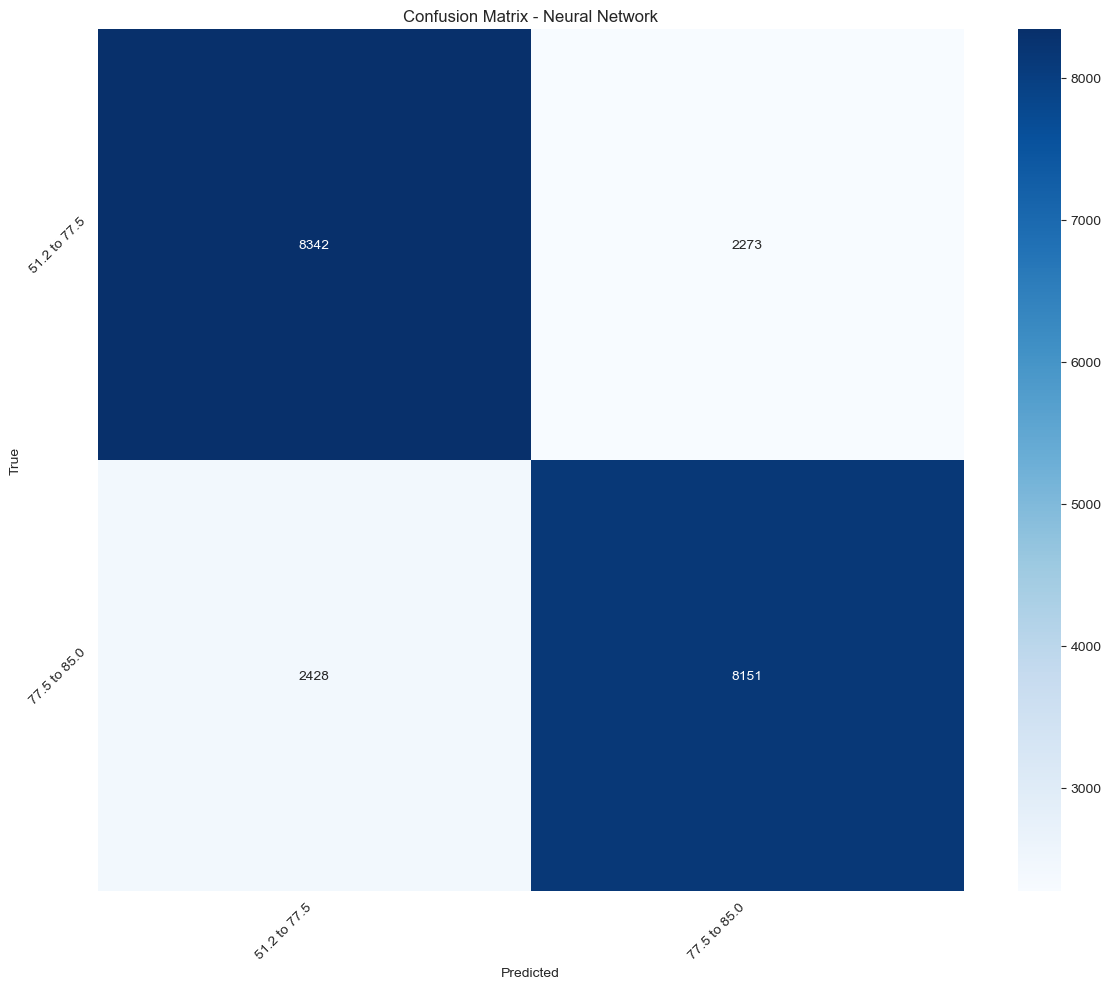

663/663 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step


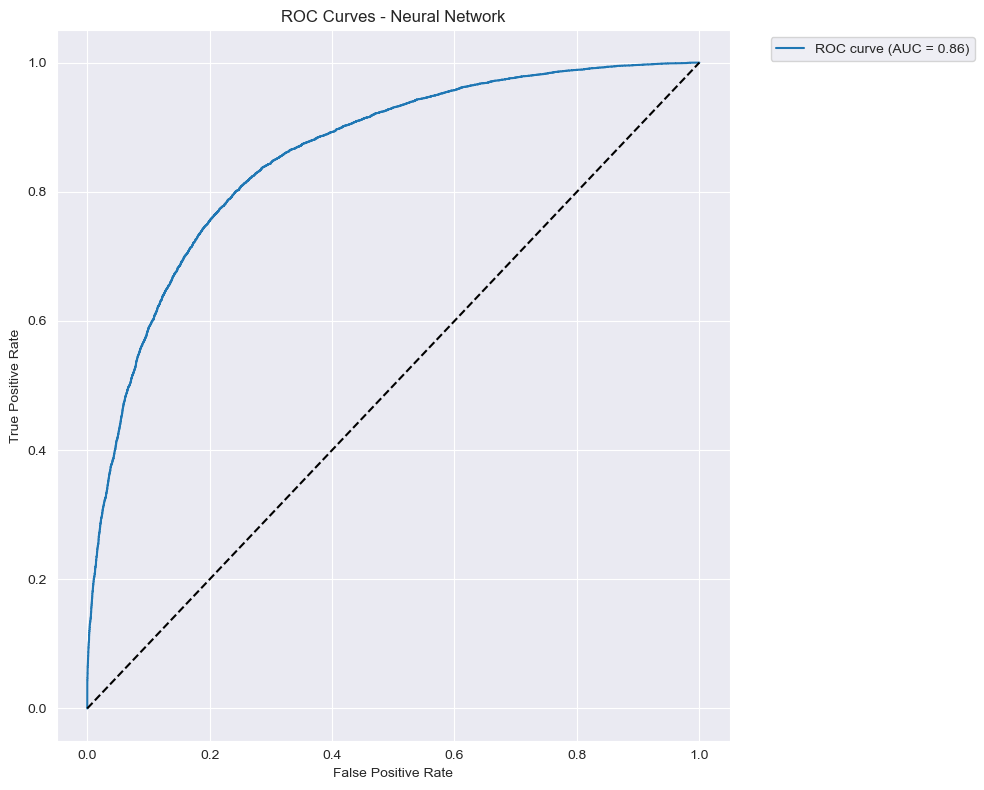


Neural Network Classification Report:
              precision    recall  f1-score   support

51.2 to 77.5       0.77      0.79      0.78     10615
77.5 to 85.0       0.78      0.77      0.78     10579

    accuracy                           0.78     21194
   macro avg       0.78      0.78      0.78     21194
weighted avg       0.78      0.78      0.78     21194



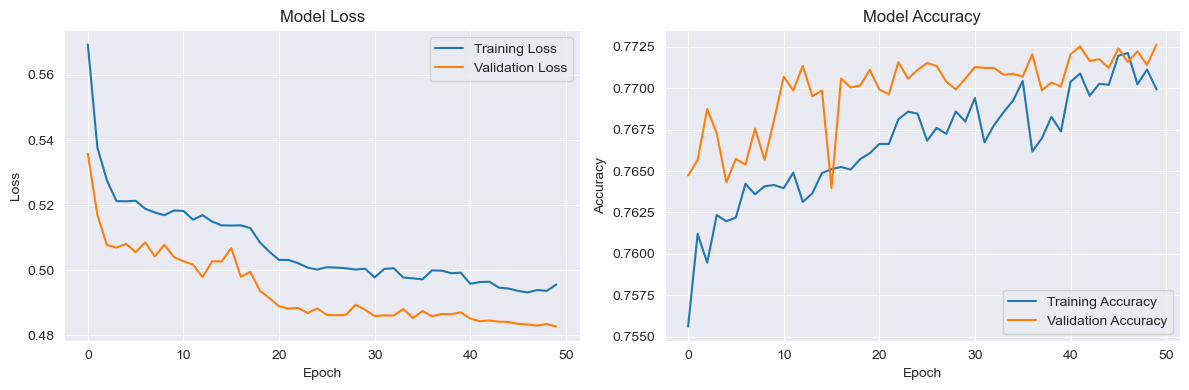

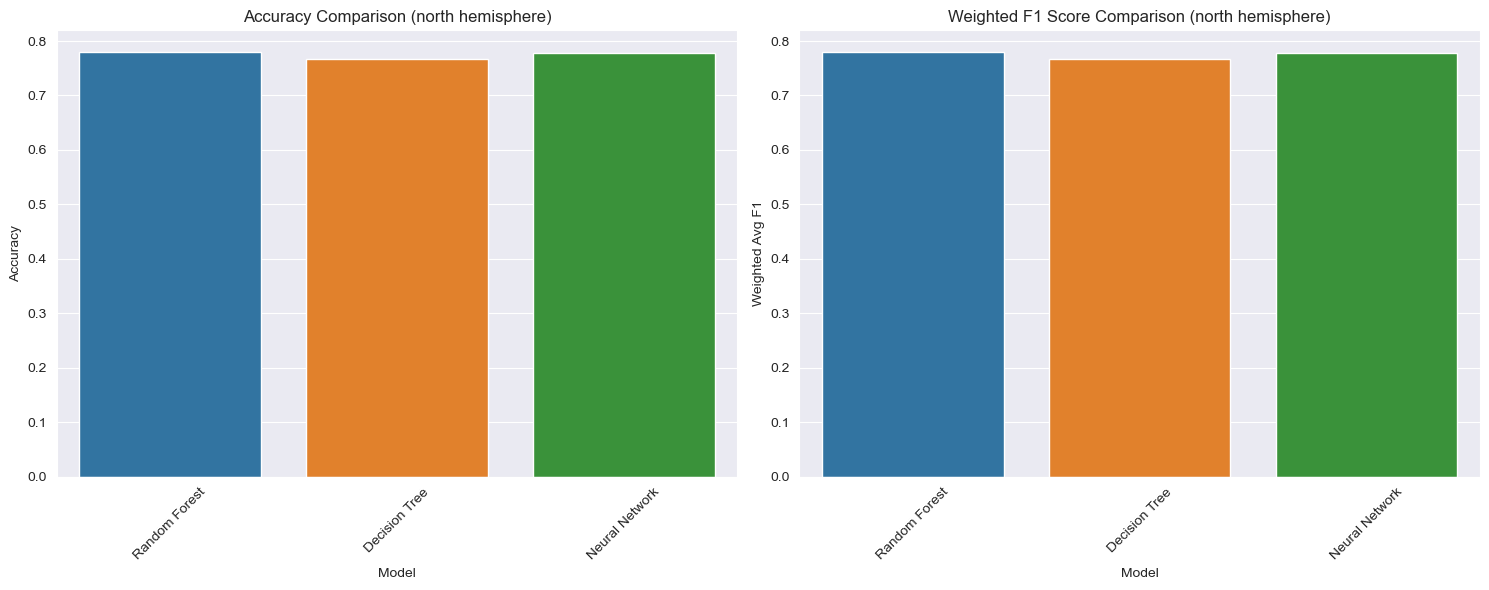


North Hemisphere Results:
            Model  Accuracy  Macro Avg F1  Weighted Avg F1
0   Random Forest  0.780504      0.780504         0.780504
1   Decision Tree  0.766868      0.766845         0.766849
2  Neural Network  0.778192      0.778174         0.778177

Training South Hemisphere Models...


/Users/beastxgamer/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1500 with 0 Axes>

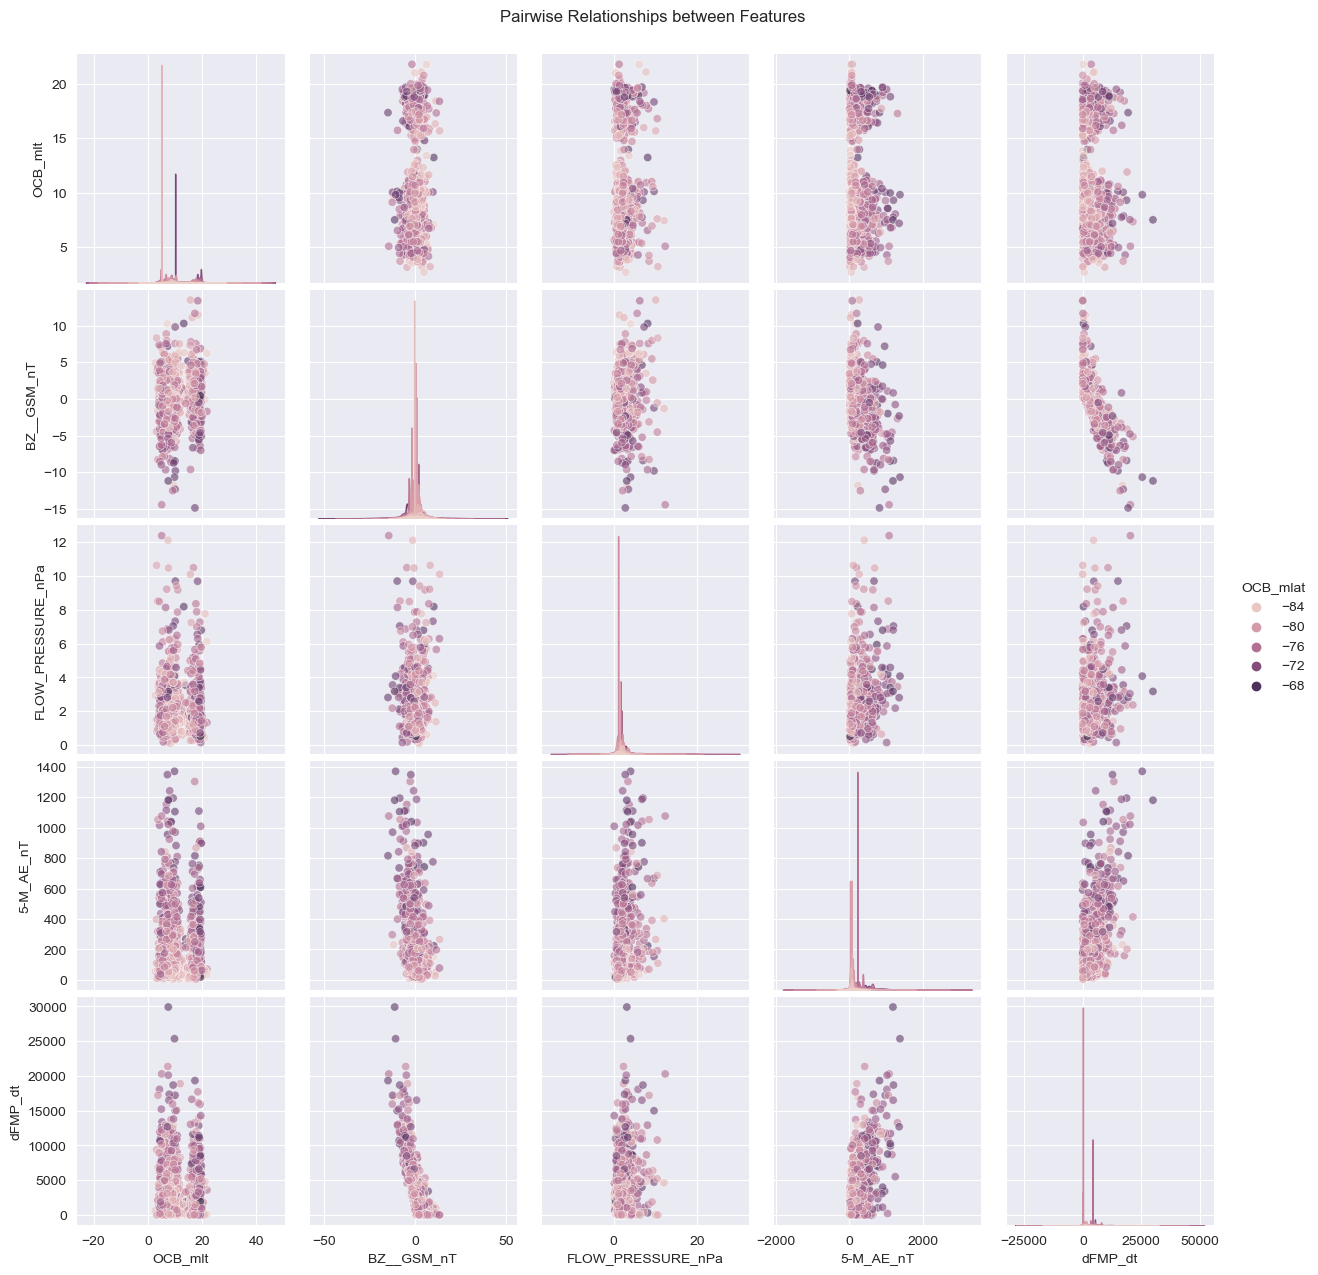


Training Random Forest...


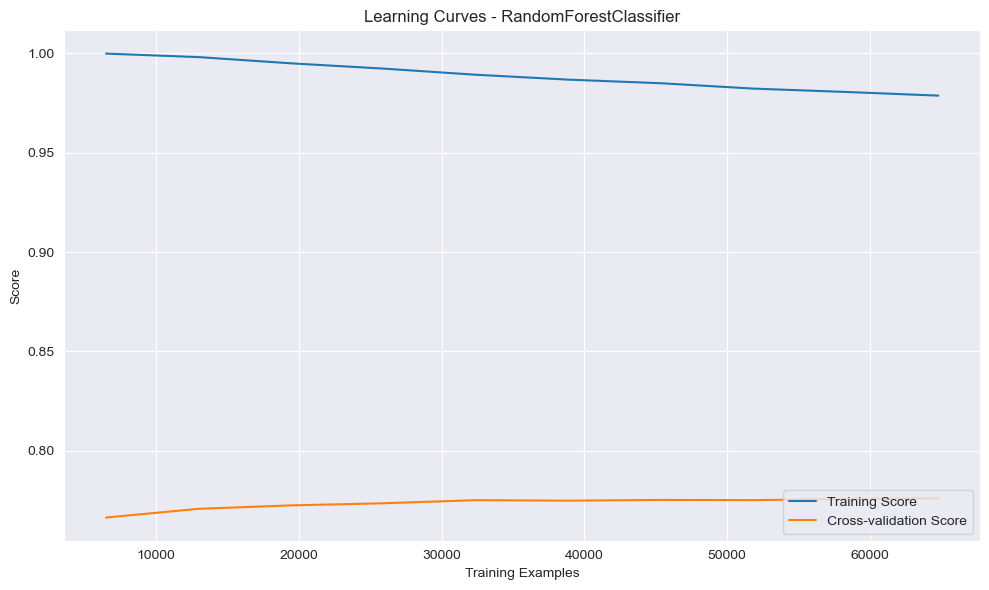

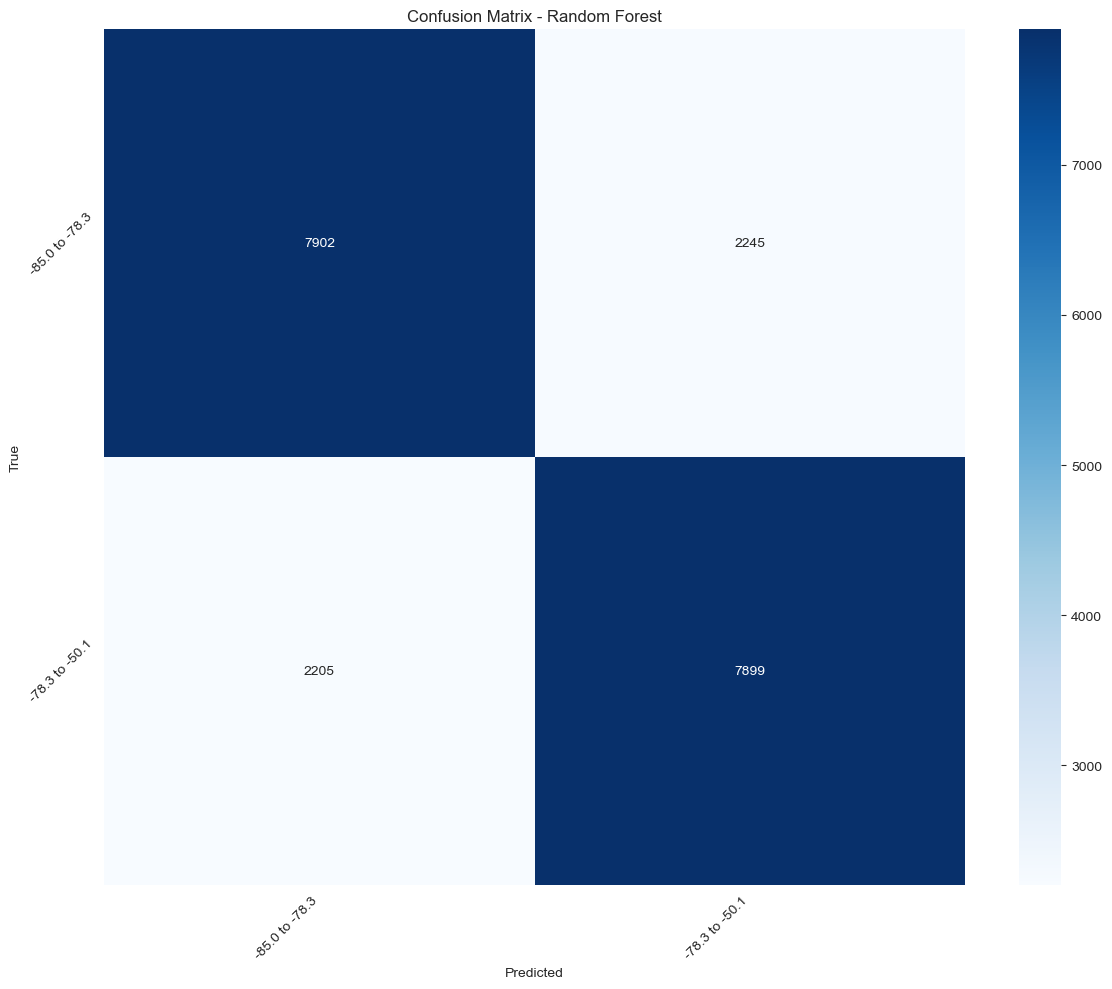

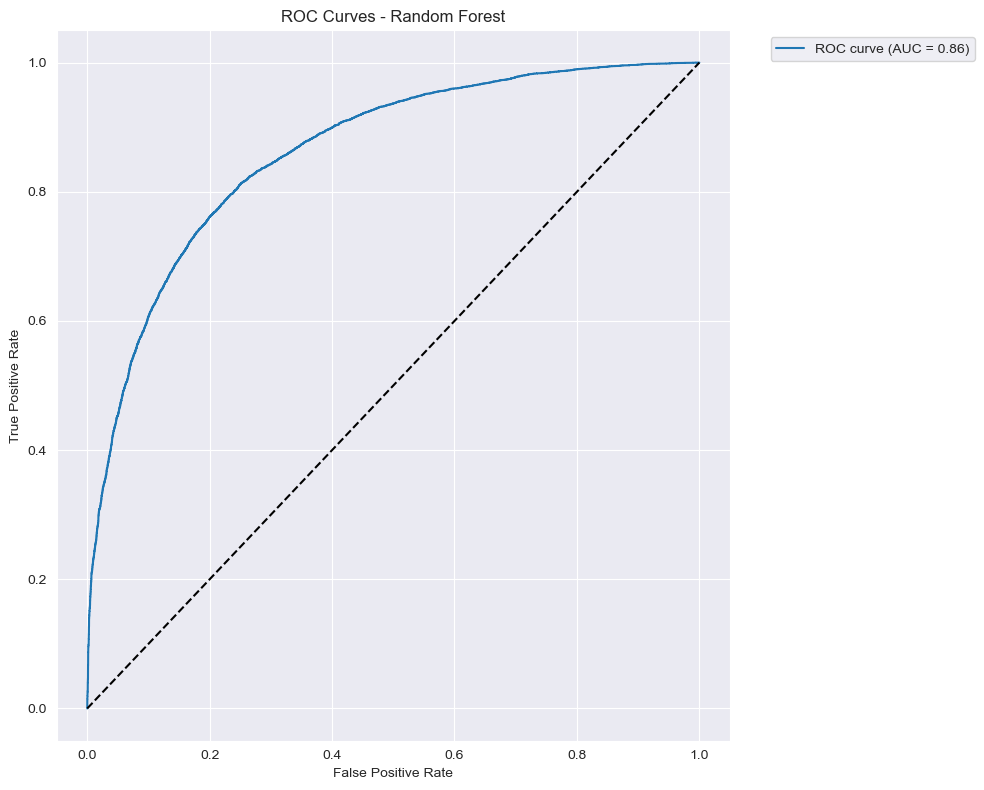

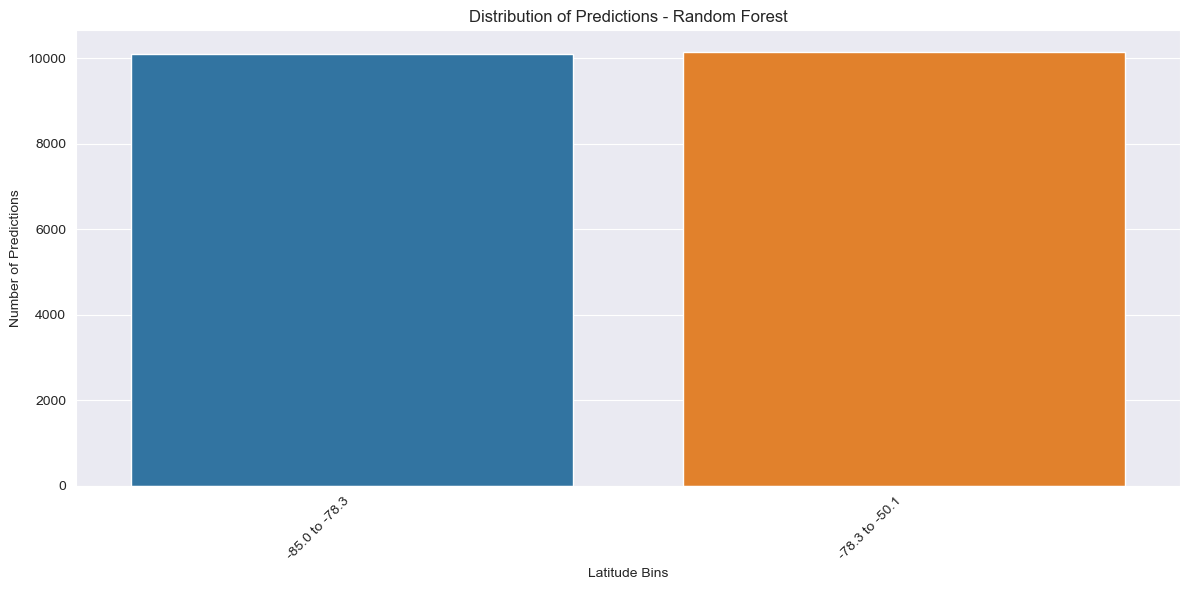

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Classification Report:
                precision    recall  f1-score   support

-85.0 to -78.3       0.78      0.78      0.78     10147
-78.3 to -50.1       0.78      0.78      0.78     10104

      accuracy                           0.78     20251
     macro avg       0.78      0.78      0.78     20251
  weighted avg       0.78      0.78      0.78     20251


Training Decision Tree...


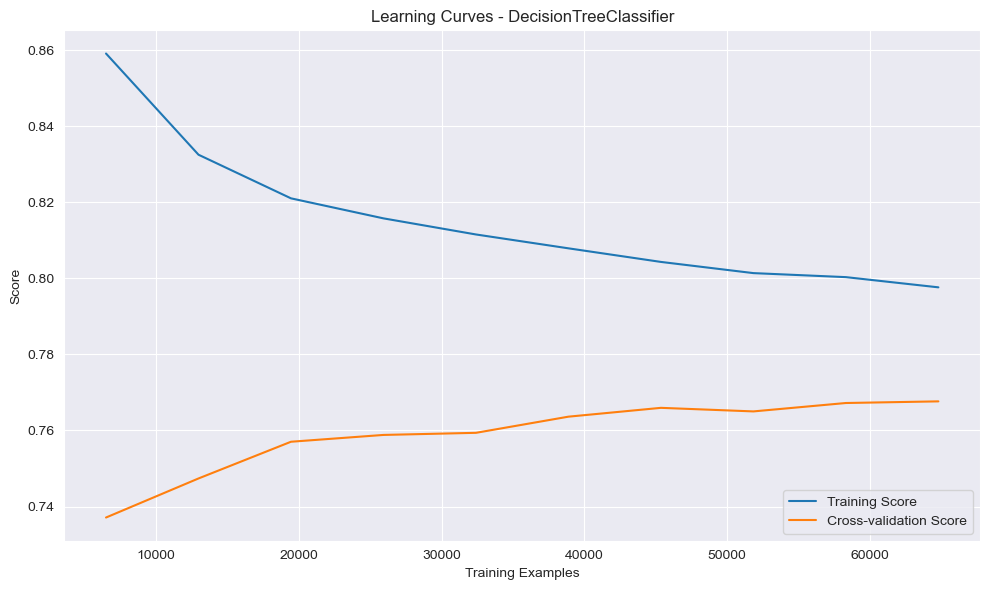

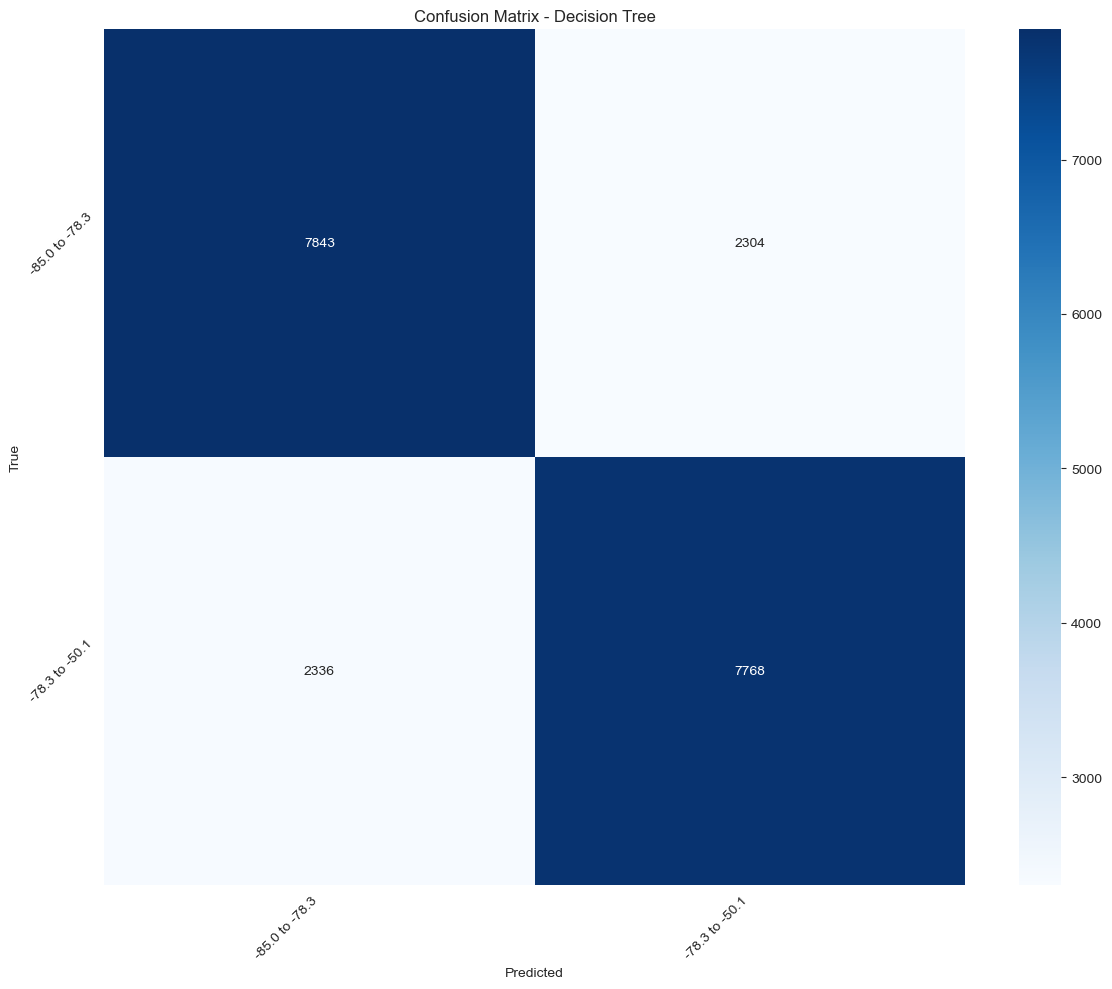

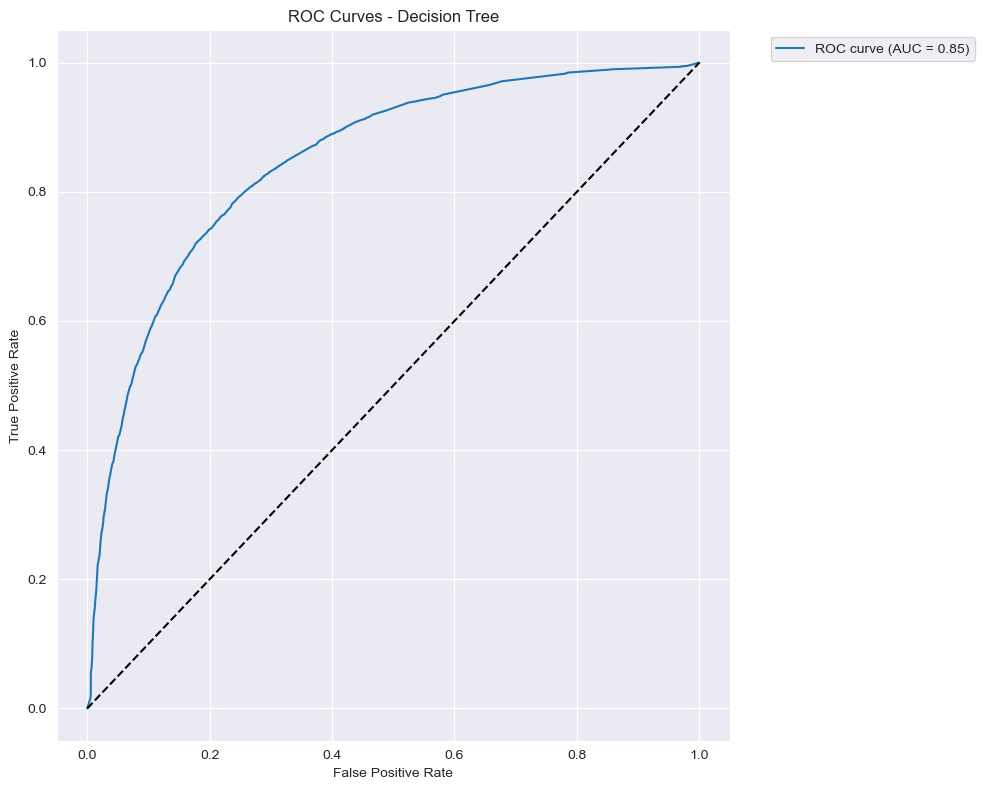

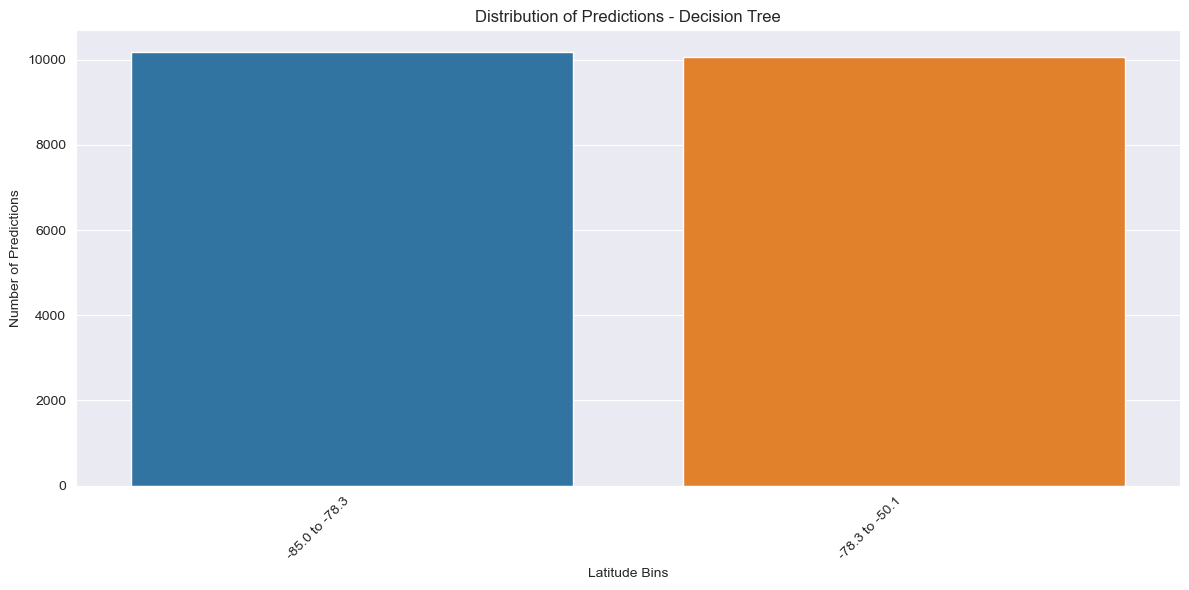

Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 2}

Classification Report:
                precision    recall  f1-score   support

-85.0 to -78.3       0.77      0.77      0.77     10147
-78.3 to -50.1       0.77      0.77      0.77     10104

      accuracy                           0.77     20251
     macro avg       0.77      0.77      0.77     20251
  weighted avg       0.77      0.77      0.77     20251



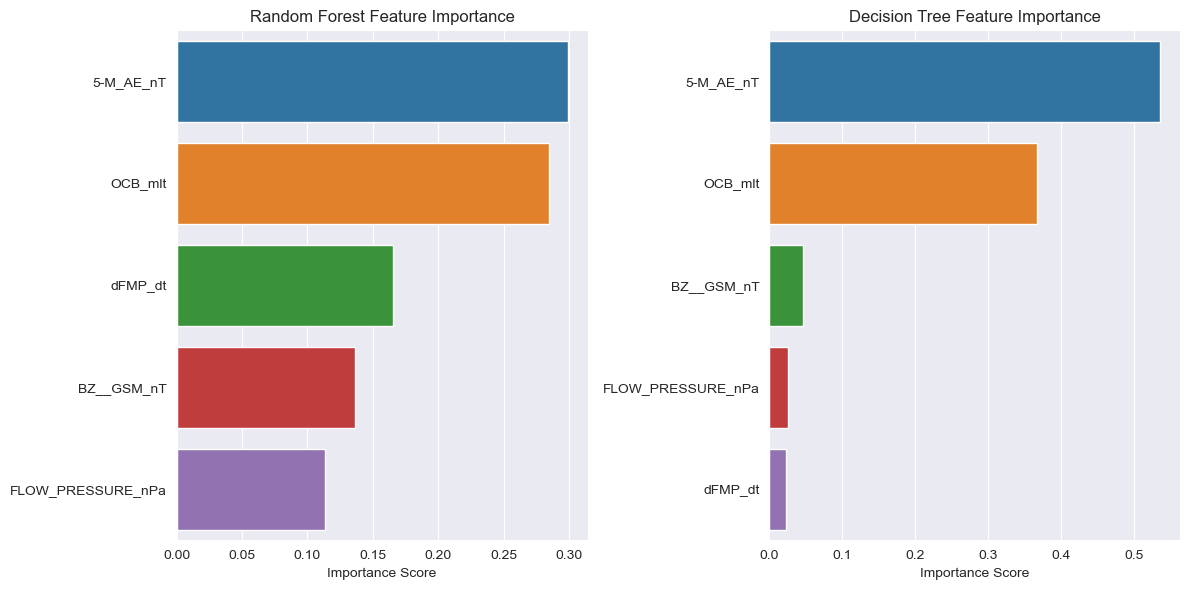


Training Neural Network...
Epoch 1/50
2026/2026 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7297 - loss: 0.5990 - val_accuracy: 0.7569 - val_loss: 0.5382 - learning_rate: 0.0010
Epoch 2/50
2026/2026 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7466 - loss: 0.5482 - val_accuracy: 0.7594 - val_loss: 0.5187 - learning_rate: 0.0010
Epoch 3/50
2026/2026 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7541 - loss: 0.5247 - val_accuracy: 0.7612 - val_loss: 0.5069 - learning_rate: 0.0010
Epoch 4/50
2026/2026 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7555 - loss: 0.5195 - val_accuracy: 0.7612 - val_loss: 0.5111 - learning_rate: 0.0010
Epoch 5/50
2026/2026 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7549 - loss: 0.5184 - val_accuracy: 0.7617 - val_loss: 0.5102 - learning_rate: 0.0010
Epoch 6/50
2026/2026 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7544 - loss: 0.5202 - val_accuracy: 0.7638 - val_loss: 0.5080 - learning_rate: 0.0010
Epoch 7/50
2026/2026 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms

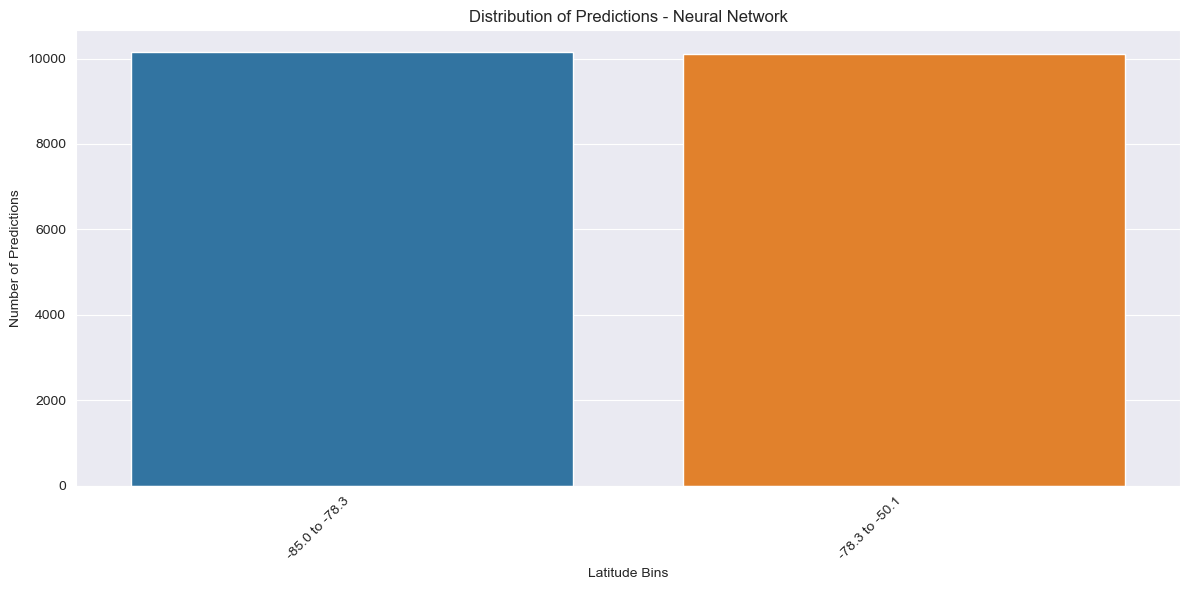

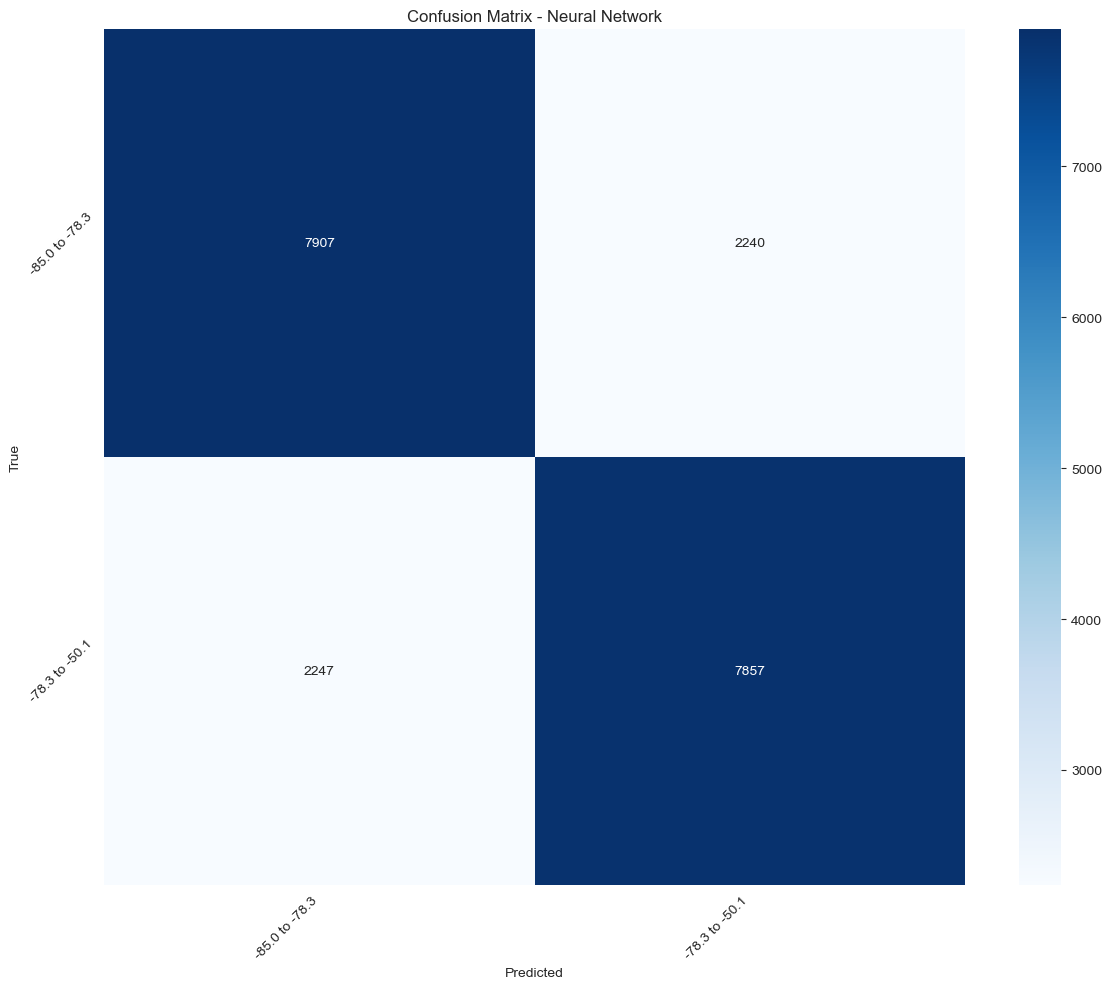

633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


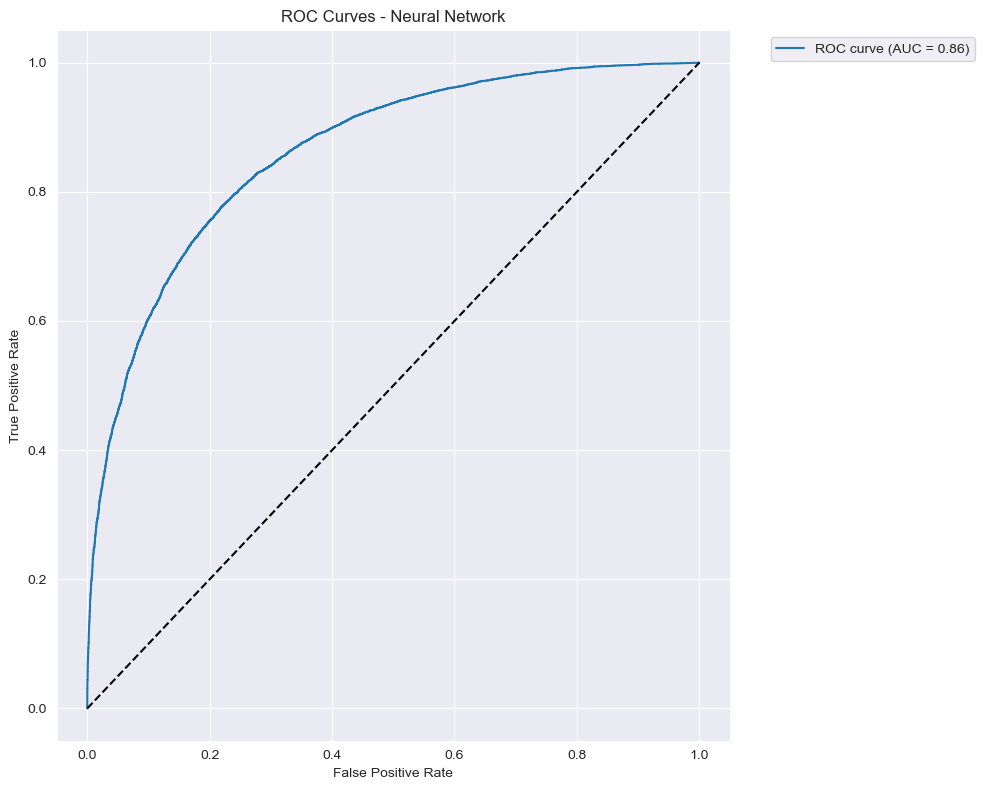


Neural Network Classification Report:
                precision    recall  f1-score   support

-85.0 to -78.3       0.78      0.78      0.78     10147
-78.3 to -50.1       0.78      0.78      0.78     10104

      accuracy                           0.78     20251
     macro avg       0.78      0.78      0.78     20251
  weighted avg       0.78      0.78      0.78     20251



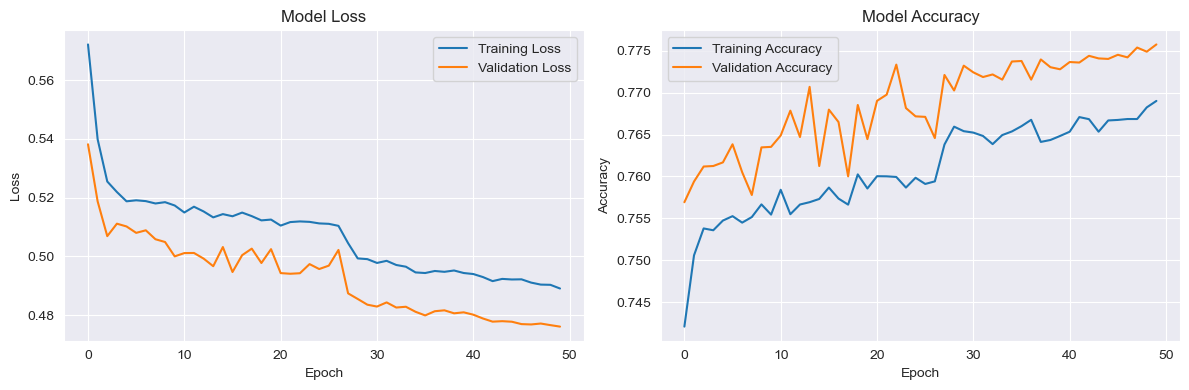

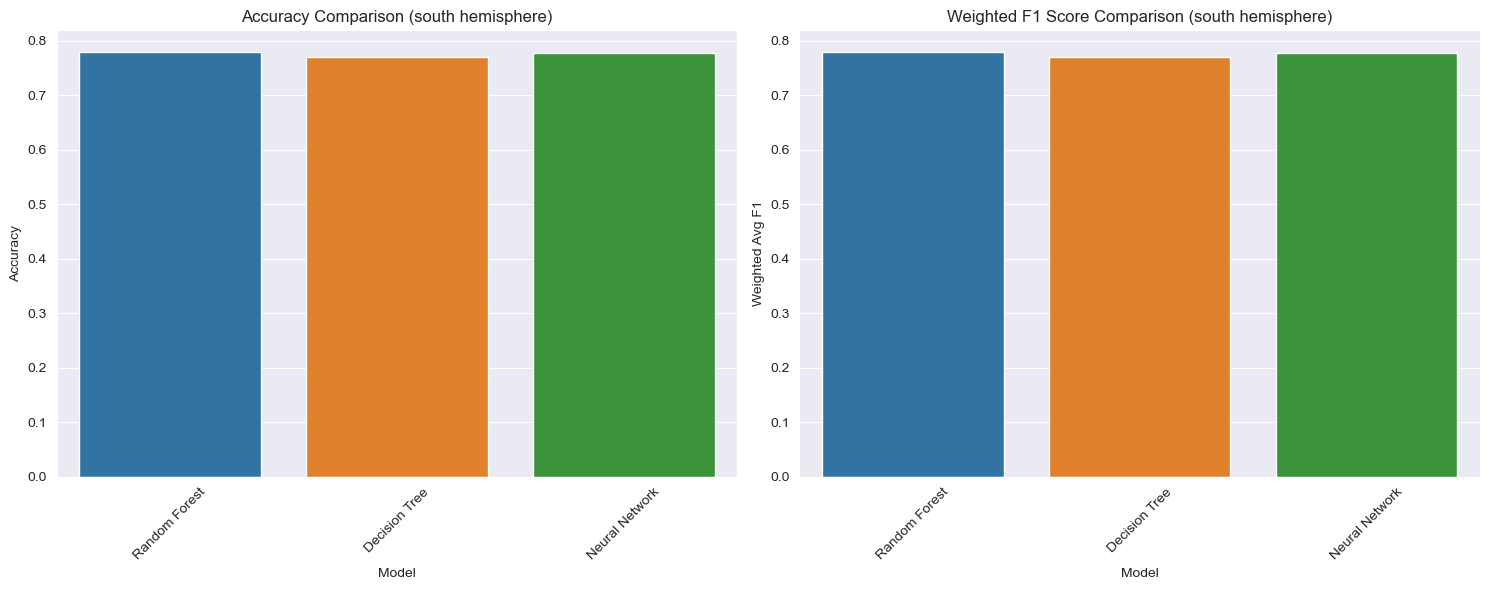


South Hemisphere Results:
            Model  Accuracy  Macro Avg F1  Weighted Avg F1
0   Random Forest  0.780258      0.780258         0.780258
1   Decision Tree  0.770876      0.770872         0.770874
2  Neural Network  0.778431      0.778429         0.778431


In [15]:
### Dayside Testing ####
# Define your features and target
features_dayside = [
    'OCB_mlt', 
    'BZ__GSM_nT',
    'FLOW_PRESSURE_nPa', 
    '5-M_AE_nT', 
    'dFMP_dt'
]
target_dayside = 'OCB_mlat'

print("Training North Hemisphere Models...")
north_results, north_models, north_scaler, north_edges, north_labels, north_history = train_classification_models(daysideN_df, features_dayside, target_dayside, 'north', n_bins=2)
print("\nNorth Hemisphere Results:")
print(north_results)

print("\nTraining South Hemisphere Models...")
south_results, south_models, south_scaler, south_edges, south_labels, south_history = train_classification_models(daysideS_df, features_dayside, target_dayside, 'south', n_bins=2)
print("\nSouth Hemisphere Results:")
print(south_results)